#Тестовое задание для аналитиков-стажеров / Сравни

## Модули

In [ ]:
# Необходимые библиотеки
! pip install pandasql
! pip install sqlalchemy==1.4.46

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=9e0058d95e88f84ab7c5492c381d21c97f5c3c21014de540bd5743b161cf180f
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.30
    Uninstalling SQLAlchemy-2.0.30:
      Successfully uninstalled SQLAlchemy-2.0.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.46 which is incompatible.


In [ ]:
from operator import attrgetter

import pandas as pd
import numpy as np
from pandasql import sqldf

import gdown

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from tqdm import tqdm

In [ ]:
# Настройка
pd.set_option('display.max_rows', 500)

# Параметры графиков
sns.set(
  font_scale=1.3,  # Размер шрифта
  style='whitegrid',  # Стиль задника, осей
  rc={'figure.figsize': (8, 5)}  # Размер диаграммы
)

## Задача 1 (SQL): Исследование данных E-commerce

### Описание задачи



---



**Задача:** Сформировать таблицу сессий пользователей из таблицы событий.

**Сессия** – набор последовательных событий по одному пользователю.

Событие считается первым в сессии (начало новой сессии) если (или):

1. Это событие - session_start
2. Предыдущие событие - session_end
3. От предыдущего события прошло более 30 минут
4. Наступил новый календарный день
5. Это первое событие пользователя за все время





Необходимо написать SQL-запрос, который создаст таблицу сессий пользователей.

Таблица должна состоять из следующих полей:
1. `SESSION_ID` – уникальный идентификатор сессии
2. `SESSION_START_DTM` – дата и время начала сессии
3. `SESSION_END_DTM` – дата и время конца сессии
4. `USER_ID` – идентификатор пользователя
5. `SESSION_NUMBER` – порядковый номер сессии для данного пользователя
6. `IS_CLIENT` – поле, которое обозначает, является ли пользователь клиентом *(пользователь является клиентом, если за всю историю у него было хотя бы одно событие purchase, не важно в рамках текущей сессии или нет)*



**Дополнительно:** сессия не может состоять только из событий session_start и session_end, такие сессии не должны попасть в результирующую таблицу и не учитываются при формировании поля SESSION_NUMBER.



---



**Важно:**

Задания на SQL выполняются с использованием синтаксиса SQLite. [Ссылка](https://www.sqlite.org/lang.html) на документацию.

**Схема данных таблицы EVENTS**

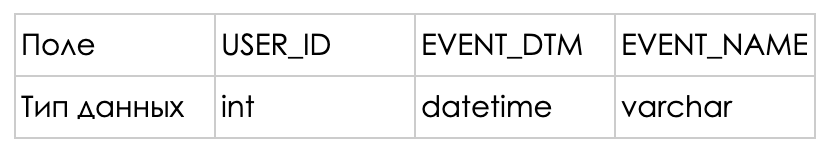

### Решение

В виде ответа на задачу необходимо прикрепить файл `result_task_1.txt` с итоговым SQL запросом в GoogleForms.

In [ ]:
# Получаем исходные данные с GDrive
url = 'https://drive.google.com/uc?export=download&id=1j2fEaQLiNHrC_OdNB9qUWqCAy-vRJSQB'
gdown.download(url)

Downloading...
From: https://drive.google.com/uc?export=download&id=1j2fEaQLiNHrC_OdNB9qUWqCAy-vRJSQB
To: /content/events.csv
100%|██████████| 906k/906k [00:00<00:00, 102MB/s]


'events.csv'

In [ ]:
# Загружаем данные
# (регистр названия DataFrame важен в SQL запросе)

events = pd.read_csv('events.csv')
events.head()

,USER_ID,EVENT_DTM,EVENT_NAME
0,921021,2023-12-01 00:13:07.000000000,event
1,921021,2023-12-01 00:13:08.000000000,event
2,193576,2023-12-01 00:13:33.000000000,event
3,193576,2023-12-01 00:13:34.000000000,event
4,921021,2023-12-01 00:17:07.000000000,event


In [ ]:
query = f"""
WITH
  prev_event_t AS (
    -- Дополнительно:
    -- - EVENT_NAME_PREV - предыдущее событие для пользователя
    -- - EVENT_DTM_PREV - предыдущее временя события пользователя
    SELECT
      *,
      LAG(EVENT_NAME, 1) OVER (
        PARTITION BY USER_ID
        ORDER BY EVENT_DTM
      ) AS EVENT_NAME_PREV,
      LAG(EVENT_DTM, 1) OVER (
        PARTITION BY USER_ID
        ORDER BY EVENT_DTM
      ) AS EVENT_DTM_PREV
    FROM events
    ORDER BY USER_ID, EVENT_DTM
  ),
  prep_event_t AS (
    -- Дополнительно:
    -- - EVENT_DTM_DIF_MIN - временя, прошедшее с предыдущего события
    -- - IS_NEW_DAY - флаг смены дня
    SELECT
      *,
      (JulianDay(EVENT_DTM) - JulianDay(EVENT_DTM_PREV)) * 24 * 60 AS EVENT_DTM_DIF_MIN,
      DATE(EVENT_DTM) != DATE(EVENT_DTM_PREV) AS IS_NEW_DAY
    FROM prev_event_t
  ),
  session_start_t AS (
    -- Дополнительно:
    -- - IS_SESSION_START - флаг начала сессии
    SELECT
      *,
      CASE
        WHEN EVENT_NAME = 'session_start' THEN 1
        WHEN EVENT_NAME_PREV = 'session_end' THEN 1
        WHEN IS_NEW_DAY = 1 THEN 1
        WHEN EVENT_DTM_DIF_MIN > 30 THEN 1
        WHEN EVENT_NAME_PREV IS NULL THEN 1
        ELSE 0
      END AS IS_SESSION_START
    FROM prep_event_t
  ),
  session_end_t_1 AS (
    -- Дополнительно:
    -- - IS_SESSION_END_RAW - флаг, что событие - конец сессии (есть NULL)
    SELECT
      *,
      LEAD(IS_SESSION_START, 1) OVER (
        PARTITION BY USER_ID
        ORDER BY EVENT_DTM
      ) AS IS_SESSION_END_RAW
    FROM session_start_t
  ),
  session_end_t AS (
    -- Дополнительно:
    -- - IS_SESSION_END - флаг, что событие - конец сессии (fix NULL)
    SELECT
      USER_ID, EVENT_DTM, IS_SESSION_START, --IS_SESSION_END_RAW,
      --*,
      CASE
        WHEN IS_SESSION_END_RAW = 1 THEN 1
        WHEN IS_SESSION_END_RAW IS NULL THEN 1
        ELSE 0
      END AS IS_SESSION_END
    FROM session_end_t_1
  ),
  short_session_filter_t_1 AS (
    -- Дополнительно:
    -- - IS_PREV_SESSION_START - флаг, что предыдущее событие - начало сессии
    -- - IS_NEXT_SESSION_END - флаг, что следующее событие - конец сессии
    SELECT
      *,
      LAG(IS_SESSION_START, 1) OVER (
        PARTITION BY USER_ID
        ORDER BY EVENT_DTM
      ) AS IS_PREV_SESSION_START,
      LEAD(IS_SESSION_END, 1) OVER (
        PARTITION BY USER_ID
        ORDER BY EVENT_DTM
      ) AS IS_NEXT_SESSION_END
    FROM session_end_t
  ),
  short_session_filter_t AS (
    -- Без сессий, которые состоят из 2х или 1 событий
    SELECT
      USER_ID, EVENT_DTM, IS_SESSION_START, IS_SESSION_END
    FROM short_session_filter_t_1
    WHERE
      NOT (IS_SESSION_START = 1 AND IS_NEXT_SESSION_END = 1)
      AND NOT (IS_SESSION_END = 1 AND IS_PREV_SESSION_START = 1)
      AND NOT (IS_SESSION_START = 1 AND IS_SESSION_END = 1)
  ),
  sessions_start_end_t AS (
    -- Сессии без промежуточных событий
    -- Дополнительно:
    -- - NEXT_EVENT_DTM - время следующего события для USER_ID
    SELECT
      *,
      LEAD(EVENT_DTM, 1) OVER (
        PARTITION BY USER_ID
        ORDER BY EVENT_DTM
      ) AS NEXT_EVENT_DTM
    FROM short_session_filter_t
    WHERE IS_SESSION_START != IS_SESSION_END
  ),
  sessions_t_1 AS (
    -- Дополнительно:
    -- - SESSION_START_DTM – дата и время начала сессии
    -- - SESSION_END_DTM – дата и время конца сессии
    -- - USER_ID – идентификатор пользователя
    SELECT
      EVENT_DTM AS SESSION_START_DTM,
      NEXT_EVENT_DTM AS SESSION_END_DTM,
      USER_ID
    FROM sessions_start_end_t
    WHERE IS_SESSION_START = 1
  ),
  is_client_t_1 AS (
    -- Заготовка для определения является ли пользователь клиентом
    -- Дополнительно:
    -- - IS_PURCHASE - флаг является событие заказом
    SELECT
      USER_ID,
      EVENT_NAME,
      CASE EVENT_NAME
        WHEN 'purchase' THEN 1
        ELSE 0
      END AS IS_PURCHASE
    FROM events
  ),
  is_client_t AS (
    -- Является ли пользователь клиентом
    SELECT
      USER_ID,
      MAX(IS_PURCHASE) AS IS_CLIENT
    FROM is_client_t_1
    GROUP BY USER_ID
  ),
  sessions_t AS (
    -- Итоговые параметры сессии:
    -- - SESSION_ID – уникальный идентификатор сессии
    -- - SESSION_START_DTM – дата и время начала сессии
    -- - SESSION_END_DTM – дата и время конца сессии
    -- - USER_ID – идентификатор пользователя
    -- - SESSION_NUMBER – порядковый номер сессии для данного пользователя
    -- - IS_CLIENT – является ли пользователь клиентом
    -- Не может ли конкретный пользователь начать и закончить 2 сессии в одно и то же время?
    SELECT
      row_number() OVER(
        ORDER BY l.SESSION_START_DTM, l.SESSION_END_DTM, l.USER_ID
      ) AS SESSION_ID,
      l.SESSION_START_DTM,
      l.SESSION_END_DTM,
      l.USER_ID,
      row_number() OVER(
        PARTITION BY l.USER_ID
        ORDER BY l.SESSION_START_DTM, l.SESSION_END_DTM
      ) AS SESSION_NUMBER,
      r.IS_CLIENT
    FROM sessions_t_1 AS l
      JOIN is_client_t AS r
      ON l.USER_ID = r.USER_ID
  )

SELECT *
FROM sessions_t
"""

sqldf(query)

,SESSION_ID,SESSION_START_DTM,SESSION_END_DTM,USER_ID,SESSION_NUMBER,IS_CLIENT
0,1,2023-12-01 00:13:07.000000000,2023-12-01 00:21:26.000000000,921021,1,1
1,2,2023-12-01 00:13:33.000000000,2023-12-01 00:31:08.000000000,193576,1,1
2,3,2023-12-01 00:31:09.000000000,2023-12-01 00:32:13.000000000,193576,2,1
3,4,2023-12-01 00:32:21.000000000,2023-12-01 00:33:22.000000000,193576,3,1
4,5,2023-12-01 00:33:24.000000000,2023-12-01 00:59:41.000000000,193576,4,1
...,...,...,...,...,...,...
1358,1359,2023-12-04 23:20:49.000000000,2023-12-04 23:42:23.000000000,156550,13,1
1359,1360,2023-12-04 23:37:30.000000000,2023-12-04 23:51:01.000000000,930053,3,0
1360,1361,2023-12-04 23:43:34.000000000,2023-12-04 23:43:38.000000000,483036,12,1
1361,1362,2023-12-04 23:48:20.000000000,2023-12-04 23:50:03.000000000,524078,7,1


In [ ]:
# Получаем файл с запросом с GDrive
url = 'https://drive.google.com/uc?export=download&id=10vWq7VkZfOCIss592I2Xc5K_yVtEa5lF'
gdown.download(url)

Downloading...
From: https://drive.google.com/uc?export=download&id=10vWq7VkZfOCIss592I2Xc5K_yVtEa5lF
To: /content/result_task_1.txt
100%|██████████| 6.07k/6.07k [00:00<00:00, 4.73MB/s]


'result_task_1.txt'

In [ ]:
with open('result_task_1.txt', 'r') as file:
    # Читаем содержимое файла
    query = file.read()

# Сохраняем результат SQL запроса в pandas DataFrame
result_task_1 = sqldf(query, globals())
result_task_1
# result_task_1.head()

,SESSION_ID,SESSION_START_DTM,SESSION_END_DTM,USER_ID,SESSION_NUMBER,IS_CLIENT
0,1,2023-12-01 00:13:07.000000000,2023-12-01 00:21:26.000000000,921021,1,1
1,2,2023-12-01 00:13:33.000000000,2023-12-01 00:31:08.000000000,193576,1,1
2,3,2023-12-01 00:31:09.000000000,2023-12-01 00:32:13.000000000,193576,2,1
3,4,2023-12-01 00:32:21.000000000,2023-12-01 00:33:22.000000000,193576,3,1
4,5,2023-12-01 00:33:24.000000000,2023-12-01 00:59:41.000000000,193576,4,1
...,...,...,...,...,...,...
1358,1359,2023-12-04 23:20:49.000000000,2023-12-04 23:42:23.000000000,156550,13,1
1359,1360,2023-12-04 23:37:30.000000000,2023-12-04 23:51:01.000000000,930053,3,0
1360,1361,2023-12-04 23:43:34.000000000,2023-12-04 23:43:38.000000000,483036,12,1
1361,1362,2023-12-04 23:48:20.000000000,2023-12-04 23:50:03.000000000,524078,7,1


## Задача 2 (SQL): Исследование данных Retail

### Описание задачи

Представь, что ты работаешь в retail компании, тебе предоставили доступ к данным компании с информацией о продажах товаров, пользователях компании, ассортименте продуктов, а также о магазинах сети. Общая схема данных выглядит следующим образом:

#### Схема базы данных

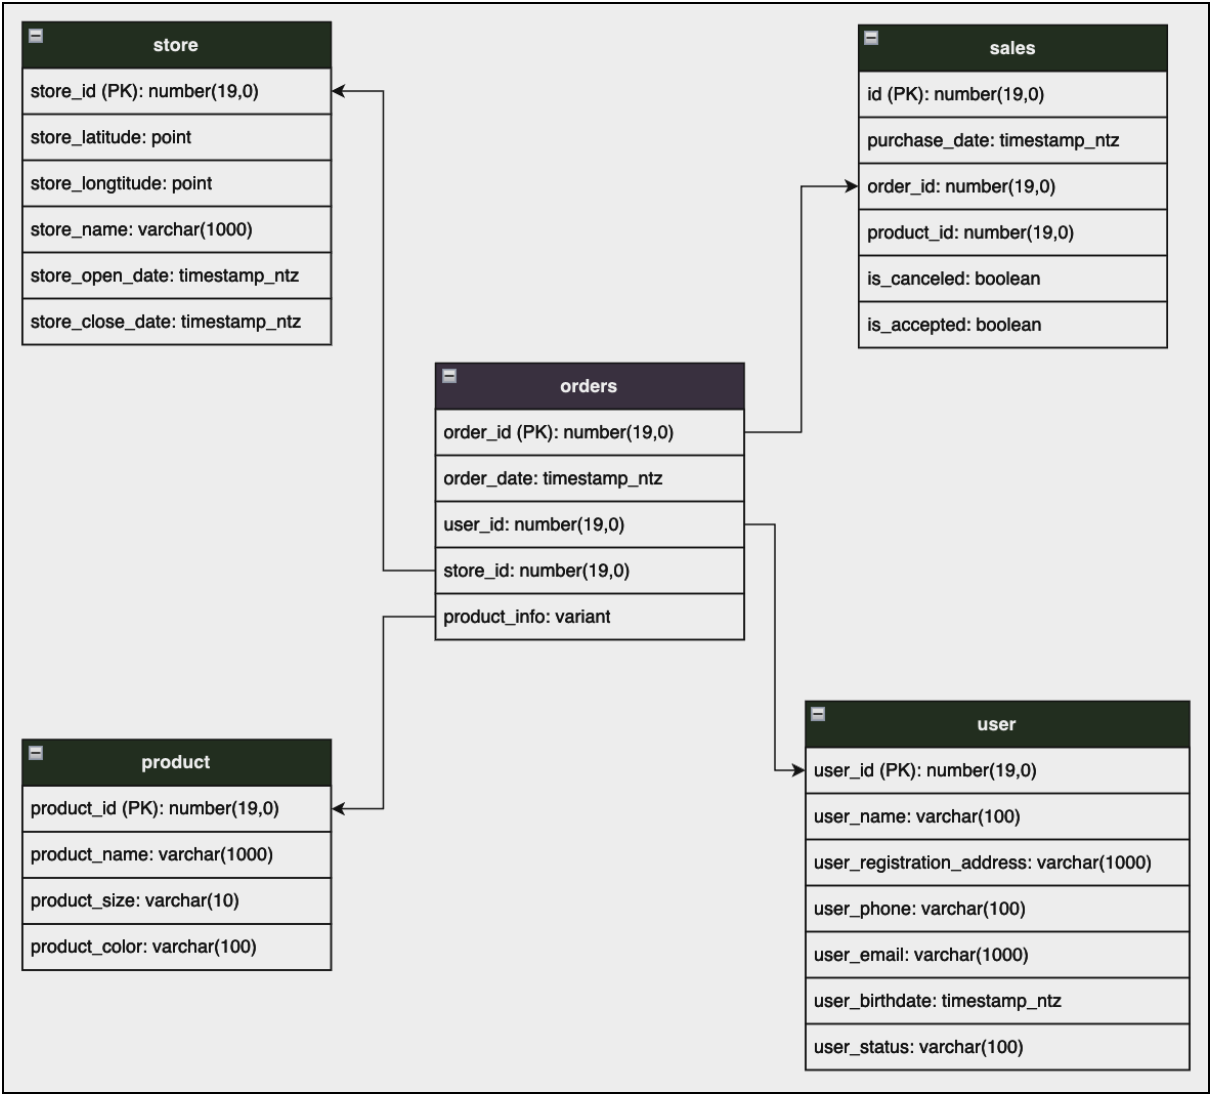

#### Описание базы данных


---



1) **orders** - таблица с информацией о созданных заказах:

* `orders.order_id`: идентификатор заказа (уникальный ключ таблицы)
* `orders.order_date`: дата создания заказа
* `orders.user_id`: идентификатор пользователя, создавшего заказ
* `orders.store_id`: идентификатор магазина, в котором был создан заказ
* `orders.product_info`: массив, содержащий json-объекты с информацией о товарах в заказе, вида:
  * `product_id` - идентификатор товара в заказе
  * `product_price` - цена товара
  * `product_commission` - комиссия за товар, учитываемая как прибыль за данный товар, получаемая компанией
  * `commission_is_percent` - флаг того, что комиссия является процентом от стоимости товара (True), либо фиксированным значением (False)
  * `count` - кол-во единиц данного продукта в заказе

**Вид массива:**

[

{"product_id":1, "product_price":1500, "product commission":70, "commission_is_percent":True, "count":2},
{"product_id":2, "product_price":2000, "product commission":1000, "commission_is_percent":False, "count":1},...

]



---



2) **sales** - таблица с информацией о продажах (совершенных платежах).
Возможные следующие случаи:
1. Если поле is_accepted=True и is_canceled=False, то произошел платеж по товару в заказе.
2. Если поле is_accepted=False и is_canceled=False, то произошло создание платежа по товару, но его еще не оплатили и не отменили.
3. Если поле is_accepted=True и is_canceled=True, то произошел возврат товара по заказу, а товар ранее был оплачен. Клиенту вернется сумма платежа.
4. Если поле is_accepted=False и is_canceled=True, то произошла отмена товара, который ранее не оплачивали.
(если статус платежа по товару меняется, то не создается новая запись в БД, а меняются поля (is_accepted, is_canceled ) в текущей записи).

**Состав таблицы:**

* `sales.id`: идентификатор продажи (уникальный ключ таблицы)
* `sales.purchase_date`: дата продажи
* `sales.order_id`: идентификатор заказа из таблицы orders, на который приходится продажа (на один заказ может быть несколько товаров, и соответственно, несколько продаж)
* `sales.product_id`: идентификатор товара в заказе
* `sales.is_accepted`: флаг подтверждения платежа
* `sales.is_canceled`: флаг подтверждения отмены платежа


---

3) **user** - таблица с информацией о клиентах:

* `user.user_id`: идентификатор пользователя (уникальный ключ таблицы)
* `user.user_name`: ФИО клиента
* `user.user_registration_address`: адрес регистрации клиента (страна/город/адрес)
* `user.user_phone`: телефон клиента
* `user.user_email`: почта клиента
* `user.user_status`: статус клиента


---


4) **store** - таблица с информацией о магазинах:

* `store.store_id`: идентификатор магазина (уникальный ключ таблицы)
* `store.store_latitude`: долгота магазина (географическая координата)
* `store.store_longtitude`: широта магазина (географическая координата)
* `store.store_name`: название магазина
* `store.store_open_date`: дата открытия магазина
* `store.store_close_date`: дата закрытия магазина



---

5) **product** - таблица с информацией о товарах:

* `product.product_id:`: идентификатор товара (уникальный ключ таблицы)
* `product.product_name`: название товара
* `product.product_size`: размер товара
* `product.product_color`: цвет товара


---



#### Постановка задачи

Необходимо создать таблицу агрегированную по пользователям и  выкупленными заказами (в каждом заказе должны быть только выкупленные товары).



* `USER_ID` - идентификатор пользователя
* `ORDER_ID` - идентификатор заказа
* `RDER_DATE` - дата создания заказа
* `ORDER_SUM` - сумма заказа
* `ORDER_REVENUE` - выручка с заказа
* `ORDER_QUANTITY` - суммарное кол-во товаров в заказе
* `ORDER_UNIQUE_PRODUCTS` - кол-во уникальных товаров в заказе (по product_id)


### Решение

В виде ответа на задачу необходимо прикрепить файл result_task_2.txt с итоговым SQL запросом в GoogleForms.

In [ ]:
# Получаем исходные данные с GDrive
urls = (
    'https://drive.google.com/file/d/1PdmWeIc0mjKGeTWRol7_c3nOSuBolbAx/view?usp=sharing',  # orders
    'https://drive.google.com/file/d/17-4DvPtQzM6YEyMXVDTxteK9XkvgKjPR/view?usp=sharing',  # product
    'https://drive.google.com/file/d/1g03VtVkG83QeKgK7eSOLn_YuHukfg9oP/view?usp=sharing',  # sales
    'https://drive.google.com/file/d/1qfbC__mgAjsKsMJ50gm0OodYNBhIU2Gi/view?usp=sharing',  # store
    'https://drive.google.com/file/d/149zSW-wlOfJtLscxR0-ZF0A8PasoDgzW/view?usp=sharing'   # user
)
for url in urls:
  url = f'https://drive.google.com/uc?export=download&id={url[32:65]}'
  gdown.download(url)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1PdmWeIc0mjKGeTWRol7_c3nOSuBolbAx
From (redirected): https://drive.google.com/uc?export=download&id=1PdmWeIc0mjKGeTWRol7_c3nOSuBolbAx&confirm=t&uuid=56feb419-9d71-4f66-9c19-74107a31a02f
To: /content/orders.csv
100%|██████████| 455M/455M [00:04<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=17-4DvPtQzM6YEyMXVDTxteK9XkvgKjPR
To: /content/product.csv
100%|██████████| 135k/135k [00:00<00:00, 53.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1g03VtVkG83QeKgK7eSOLn_YuHukfg9oP
From (redirected): https://drive.google.com/uc?export=download&id=1g03VtVkG83QeKgK7eSOLn_YuHukfg9oP&confirm=t&uuid=b9499a36-9bf0-41d0-bd94-c4449cc87da8
To: /content/sales.csv
100%|██████████| 138M/138M [00:01<00:00, 72.9MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1qfbC__mgAjsKsMJ50gm0OodYNBhIU2Gi
To: /content/store.csv
100%|██████████| 79

In [ ]:
# Загружаем данные
# (регистр названия DataFrame важен в SQL запросе)

orders = pd.read_csv('orders.csv')
sales = pd.read_csv('sales.csv')
user = pd.read_csv('user.csv')
store = pd.read_csv('store.csv')
product = pd.read_csv('product.csv')

orders.head()

,order_id,order_date,user_id,store_id,product_info
0,1,2022-01-11,13,6,"[{'product_id': 3283, 'product_price': 18245.9..."
1,2,2022-01-11,70,6,"[{'product_id': 505, 'product_price': 11060.84..."
2,3,2022-01-11,75,6,"[{'product_id': 1546, 'product_price': 3065.23..."
3,4,2022-01-11,172,6,"[{'product_id': 3354, 'product_price': 7131.35..."
4,5,2022-01-11,176,6,"[{'product_id': 3595, 'product_price': 13762.1..."


In [ ]:
query = """
WITH
  orders_fix_t AS (
    -- Пофикшены данные bool типа и кавычки для столбца product_info (для json)
    SELECT
      order_id, order_date, user_id, store_id,
      REPLACE(
        REPLACE(
          REPLACE(product_info
            , 'True', '1')
            ,  'False', '0')
            , '''', '"') AS product_info
    FROM orders
  ),
  orders_products_t AS (
    -- Информация по продуктам в заказах
    -- * Есть странные товары с product_price == 0
    -- * Есть странные товары с product_price == 0, comission_is_percent == 0, product_comission > 0
    SELECT
      order_id, order_date, user_id, store_id,
      json_extract(pi.value, '$.product_id') AS product_id,
      json_extract(pi.value, '$.product_price') AS product_price,
      json_extract(pi.value, '$.product_comission') AS product_comission,
      json_extract(pi.value, '$.comission_is_percent') AS comission_is_percent,
      json_extract(pi.value, '$.count') AS count
    FROM
      orders_fix_t,
      JSON_EACH(product_info) AS pi
  ),
  sales_sx_t AS (
    -- Выкупленные продукты в заказах
    SELECT *
    FROM sales
    WHERE
      is_accepted = 1
      AND is_canceled = 0
  ),
  products_sx_t AS (
    -- Выкупленные продукты в заказах с информацией по ним
    -- * Значений больше, чем в sales_sx_t (тк в orders_products_t есть повторения по order_id, product_id (например, из-за разной комиссии))
    -- Дополнительно:
    -- - profit_per_1 - прибыль с единицы товара
    SELECT
      l.order_id, l.product_id, order_date, user_id, product_price, product_comission, comission_is_percent, count,
      CASE comission_is_percent
        WHEN 1 THEN product_price * product_comission / 100
        WHEN 0 THEN product_comission
      END AS profit_per_1
    FROM orders_products_t AS l
      JOIN sales_sx_t AS r
      ON l.order_id = r.order_id
      AND l.product_id = r.product_id
  ),
  positions_t AS (
    -- Информация по позициям в заказе
    SELECT
      user_id,
      order_id,
      order_date,
      product_id,
      product_price * count AS product_price_sum,
      profit_per_1 * count AS profit_sum,
      count
    FROM products_sx_t
  ),
  orders_info_t AS (
    -- Информация по заказам
    -- * Вместо ORDER_REVENUE посчитал ORDER_PROFIT, тк в моём понимании выручка - это ORDER_SUM
    -- USER_ID - идентификатор пользователя
    -- ORDER_ID - идентификатор заказа
    -- ORDER_DATE - дата создания заказа
    -- ORDER_SUM - сумма заказа
    -- ORDER_PROFIT - прибыль с заказа
    -- ORDER_QUANTITY - суммарное кол-во товаров в заказе
    -- ORDER_UNIQUE_PRODUCTS - кол-во уникальных товаров в заказе (по product_id)
    SELECT
      user_id AS USER_ID,
      order_id as ORDER_ID,
      order_date as ORDER_DATE,
      SUM(product_price_sum) AS ORDER_SUM,
      SUM(profit_sum) AS ORDER_PROFIT,
      SUM(count) AS ORDER_QUANTITY,
      COUNT(DISTINCT product_id) AS ORDER_UNIQUE_PRODUCTS
    FROM positions_t
    GROUP BY user_id, order_id, order_date
  )

SELECT *
FROM orders_info_t

--ORDER BY USER_ID, ORDER_ID
"""

df = sqldf(query)
df

,USER_ID,ORDER_ID,ORDER_DATE,ORDER_SUM,ORDER_PROFIT,ORDER_QUANTITY,ORDER_UNIQUE_PRODUCTS
0,1,6116,2022-03-11,11060.841781,3500.000000,1,1
1,1,22551,2022-06-01,16349.124324,5000.000000,1,1
2,1,29821,2022-06-25,42317.548321,9472.572928,2,2
3,1,35739,2022-07-14,105079.580832,42848.594884,7,7
4,1,42149,2022-08-04,9200.386361,2500.000000,1,1
...,...,...,...,...,...,...,...
561312,10000,455738,2023-08-21,23025.919693,17269.439770,1,1
561313,10000,469917,2023-08-25,46085.184576,10197.839208,3,3
561314,10000,487451,2023-08-30,87361.095777,27124.510170,7,7
561315,10000,501455,2023-09-03,16349.124324,4000.000000,1,1


In [ ]:
# Получаем файл с запросом с GDrive
url = 'https://drive.google.com/uc?export=download&id=15DJurHyTjQe4duNaWjOdsPPl0hvUSFbF'
gdown.download(url)

Downloading...
From: https://drive.google.com/uc?export=download&id=15DJurHyTjQe4duNaWjOdsPPl0hvUSFbF
To: /content/result_task_2.txt
100%|██████████| 3.62k/3.62k [00:00<00:00, 2.96MB/s]


'result_task_2.txt'

In [ ]:
with open('result_task_2.txt', 'r') as file:
    # Читаем содержимое файла
    query = file.read()

# Сохраняем результат SQL запроса в pandas DataFrame
result_task_2 = sqldf(query, globals())
result_task_2.head()

,USER_ID,ORDER_ID,ORDER_DATE,ORDER_SUM,ORDER_PROFIT,ORDER_QUANTITY,ORDER_UNIQUE_PRODUCTS
0,1,6116,2022-03-11,11060.841781,3500.000000,1,1
1,1,22551,2022-06-01,16349.124324,5000.000000,1,1
2,1,29821,2022-06-25,42317.548321,9472.572928,2,2
3,1,35739,2022-07-14,105079.580832,42848.594884,7,7
4,1,42149,2022-08-04,9200.386361,2500.000000,1,1


## Задача 3 (Python/R): Подготовка к встрече с новым владельцем сети магазинов

### Описание задачи

3.1 Завтра состоится встреча с новым владельцами бизнеса. Тебе предстоит подготовить информацию для встречи, где были бы собраны ключевые метрики, графики и сегменты на твой взгляд.

Ты можешь использовать любые данные из задачи 2, любые библиотеки и методы, которые посчитаете необходимыми. Решение предлагается сделать в свободной форме, все файлы результата и реализации выложить в GoogleDrive, ссылку прикрепить в GoogleForms (не забудь предоставить доступы). Единственное ограничение - код должен быть написан на Python или R.

3.2 У Product Ownerа есть желание понять, сколько единиц каждого товара необходимо поставить в каждый из магазинов в следующем месяце. Целью является совершить одну поставку товара в начале месяца и не довозить его больше, до начала следующего.

Ты можешь использовать любые данные из задачи 2, любые библиотеки и методы, которые посчитаете необходимыми. Решение предлагается сделать в свободной форме, все файлы результата и реализации выложить в GoogleDrive, ссылку прикрепить в GoogleForms (не забудь предоставить доступы). Единственное ограничение - код должен быть написан на Python или R.


### Решение 3.1.

Идеи.

Retail компания.

**Ключевые метрики:**
- выручка
- прибыль
- Profit ratio
- CR (в покупку) – не получится посчитать, тк нет данных по действиям пользователей помимо покупок
- customer_retention
- LTV? (для прикидывания маркетинга)

Представление:
- факт
- динамика
- прогноз? (избыточно для тестового)

\
\* *Остальное хоть и не ключевое, но имхо представляет интерес для нового владельца*

**Мерики тщеславия:**
- отказы
- структура выручки
  - DAU (+ мб структура - опосредованно в retention)
  - ARPPU
- магазины
  - количество
  - выручка по магазинам?

**Дополнительная информация:**
- магазины
  - местоположение
- клиенты
  - местоположение
  - возраст
- stickness?
- RFM сегментация?

#### Подготовка данных

In [ ]:
# Чуть модифицированный использованный ранее запрос
query = """
WITH
  orders_fix_t AS (
    -- Пофикшены данные bool типа и кавычки для столбца product_info (для json)
    SELECT
      order_id, order_date, user_id, store_id,
      REPLACE(
        REPLACE(
          REPLACE(product_info
            , 'True', '1')
            ,  'False', '0')
            , '''', '"') AS product_info
    FROM orders
  ),
  orders_products_t AS (
    -- Информация по продуктам в заказах
    -- * Есть странные товары с product_price == 0
    -- * Есть странные товары с product_price == 0, comission_is_percent == 0, product_comission > 0
    SELECT
      order_id, order_date, user_id, store_id,
      json_extract(pi.value, '$.product_id') AS product_id,
      json_extract(pi.value, '$.product_price') AS product_price,
      json_extract(pi.value, '$.product_comission') AS product_comission,
      json_extract(pi.value, '$.comission_is_percent') AS comission_is_percent,
      json_extract(pi.value, '$.count') AS count
    FROM
      orders_fix_t,
      JSON_EACH(product_info) AS pi
  ),
  sales_sx_t AS (
    -- Выкупленные продукты в заказах
    SELECT *
    FROM sales
    WHERE
      is_accepted = 1
      AND is_canceled = 0
  ),
  products_sx_t AS (
    -- Выкупленные продукты в заказах с информацией по ним
    -- * Значений больше, чем в sales_sx_t (тк в orders_products_t есть повторения по order_id, product_id (например, из-за разной комиссии))
    -- Дополнительно:
    -- - profit_per_1 - прибыль с единицы товара
    SELECT
      l.order_id, l.product_id, order_date, user_id, product_price, product_comission, comission_is_percent, count, store_id,
      CASE comission_is_percent
        WHEN 1 THEN product_price * product_comission / 100
        WHEN 0 THEN product_comission
      END AS profit_per_1
    FROM orders_products_t AS l
      JOIN sales_sx_t AS r
      ON l.order_id = r.order_id
      AND l.product_id = r.product_id
  ),
  positions_t AS (
    -- Информация по позициям в заказе
    SELECT
      user_id,
      order_id,
      order_date,
      product_id,
      product_price * count AS product_price_sum,
      profit_per_1 * count AS profit_sum,
      count,
      store_id
    FROM products_sx_t
  ),
  orders_info_t AS (
    -- Информация по заказам
    SELECT
      user_id,
      order_id,
      store_id,
      order_date AS date,
      SUM(product_price_sum) AS revenue,
      SUM(profit_sum) AS profit,
      SUM(count) AS quantity,
      COUNT(DISTINCT product_id) AS unique_products
    FROM positions_t
    GROUP BY user_id, order_id, store_id, date
  )

SELECT *
FROM orders_info_t
"""

orders_info_df = sqldf(query)
orders_info_df

,user_id,order_id,store_id,date,revenue,profit,quantity,unique_products
0,1,6116,6,2022-03-11,11060.841781,3500.000000,1,1
1,1,22551,6,2022-06-01,16349.124324,5000.000000,1,1
2,1,29821,5,2022-06-25,42317.548321,9472.572928,2,2
3,1,35739,6,2022-07-14,105079.580832,42848.594884,7,7
4,1,42149,5,2022-08-04,9200.386361,2500.000000,1,1
...,...,...,...,...,...,...,...,...
561312,10000,455738,15,2023-08-21,23025.919693,17269.439770,1,1
561313,10000,469917,15,2023-08-25,46085.184576,10197.839208,3,3
561314,10000,487451,15,2023-08-30,87361.095777,27124.510170,7,7
561315,10000,501455,15,2023-09-03,16349.124324,4000.000000,1,1


In [ ]:
# Приведение типов
orders_info_df.date = pd.to_datetime(orders_info_df.date)
orders_info_df.dtypes

user_id                     int64
order_id                    int64
store_id                    int64
date               datetime64[ns]
revenue                   float64
profit                    float64
quantity                    int64
unique_products             int64
dtype: object

In [ ]:
# Псевдоним, чтобы не ждать запрос
money_df = orders_info_df.copy()

In [ ]:
# Проверка, что ничего не потеряли
sales.query('is_canceled == False and is_accepted == True').order_id.nunique()

561317

In [ ]:
# Последнее число месяца
last_date = money_df.date.max()
last_date
# => последний месяц неполный

Timestamp('2023-10-10 00:00:00')

In [ ]:
# # Убираем последнее число месяца (неполная статистика по дню)
# money_df = money_df[money_df.date < last_date]
# money_df.date.max()

In [ ]:
# Убираем последний неполный месяц
last_month = money_df.date.max().to_numpy().astype('datetime64[M]')
money_df = money_df[money_df.date < last_month]
money_df.date.max()

Timestamp('2023-09-30 00:00:00')

In [ ]:
money_month_df = money_df.set_index('date').resample('M').sum().reset_index()
money_month_df['profit_ratio'] = (money_month_df.profit / money_month_df.revenue).mul(100).round(1)  # Перерасчёт
money_month_df

,date,user_id,order_id,store_id,revenue,profit,quantity,unique_products,profit_ratio
0,2022-01-31,5982748,2470550,13074,8.285453e+07,2.714232e+07,6011,5367,32.8
1,2022-02-28,7453649,10099488,16416,1.137556e+08,3.852846e+07,8182,6865,33.9
2,2022-03-31,8618944,21081961,18786,1.314468e+08,4.323767e+07,9721,8270,32.9
3,2022-04-30,15966087,65418419,32034,2.192160e+08,7.514304e+07,15980,13907,34.3
4,2022-05-31,25101309,143328058,47300,3.086705e+08,1.028020e+08,22431,20004,33.3
5,2022-06-30,33429155,241804803,59464,3.591992e+08,1.176634e+08,25943,23199,32.8
6,2022-07-31,34251078,332944412,61061,3.652051e+08,1.208543e+08,26603,22718,33.1
7,2022-08-31,34164682,421571278,60964,3.556433e+08,1.216775e+08,25780,22932,34.2
8,2022-09-30,64029688,684366387,107086,4.759637e+08,1.595188e+08,34667,29243,33.5
9,2022-10-31,79352629,1043412900,128312,5.946478e+08,2.015706e+08,42756,38716,33.9


#### Ключевые метрики

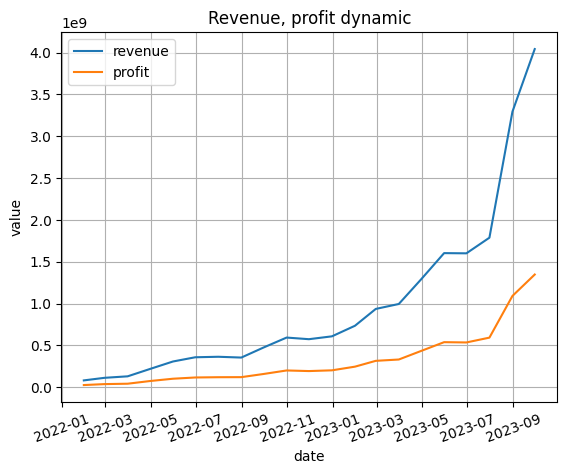

In [ ]:
# Динамика revenue, profit
metrics = ['revenue', 'profit']
for metric in metrics:
  sns.lineplot(data=money_month_df, x='date', y=metric, label=metric);
plt.grid();
plt.xticks(rotation=20);
plt.ylabel('value');
plt.title('Revenue, profit dynamic');

In [ ]:
# Факт revenue, profit
money_df[metrics].sum()

revenue    2.047856e+10
profit     6.845597e+09
dtype: float64

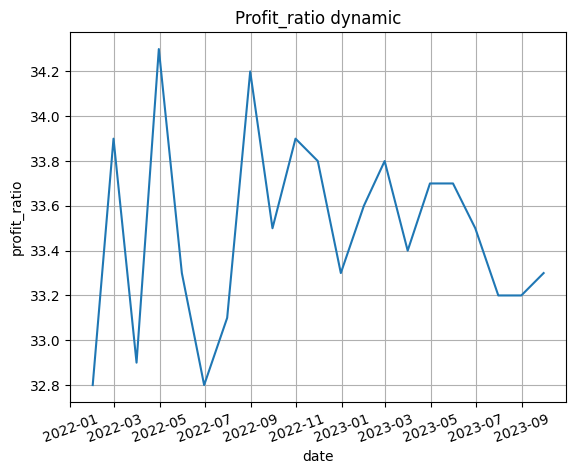

In [ ]:
# Динамика profit_ratio
metric_name = 'profit_ratio'
sns.lineplot(data=money_month_df, x='date', y=metric_name);
plt.grid();
plt.xticks(rotation=20);
plt.ylabel(metric_name);
plt.title(f'{metric_name.capitalize()} dynamic');
# Со временем снижается изменчивость

In [ ]:
def get_cohort_analysis(
    df,
    unit_column,
    value_column,
    time_column,
    metric_func,
    segments_time_interval=None,
    normalize=False,
    percents=False,
    style=True,
    round_val=2,
    gradient_axis=None,
    gradient_max_val=None,
    gradient_min_val=None
):
    '''
    Функция возвращает таблицу для проведения когортного анализа

    Parameters
    ----------
    df: pandas.DataFrame
        Исходный df
    unit_column: str
        Название колонки с единицей для когортного анализа (напр.: id пользователя)
    value_column: str
        Название колонки, которая будет использоваться для непосредственного
        расчёта метрики когортного анализа
    time_colunm: str
        Название колонки с временными отсчётами
    metric_func: callable
        Функция для расчёта метрики по когортам
        'retention': pd.Series.nunique
    normalize: bool, default False
        Нормализация по max значению
    percents: bool, default False
        Перевод в %
    segments_time_interval: list(str, str)
        Временной интервал для фильтрации сегментов
    style: bool, default True
        Флаг стилизации итоговой сводной таблицы с помощью heatmap
    round_val: int, default 2
        Количество знаков после запятой при округлении метрики
    gradient_axis, {0, 1, “index”, “columns”, None}, default None
        Выбор оси для применения градиента
        axis=0    : 'index'
        axis=1    : 'columns'
        axis=None : all DataFrame
    gradient_max_val: float, default None
        Максимальное значение для heatmap
    gradient_min_val: float, default None
        Минимальное значение для heatmap

    Returns
    -------
    cohorts_df: pandas.DataFrame
        Сводная таблица для выполнения когортного анализа
    '''

    # Добавление столбца с временными периодами
    df['period'] = (
        df[time_column]
        .dt.to_period('M')
    )
    # Добавление столбца соответствия единицы когортного анализа и сегмента
    segmment_compliance = (
        df
        .groupby(unit_column, as_index=False)
        .period.min()
        .rename(columns={'period': 'segment'})
    )
    # Добавление информации о сегментах в исходный df
    df = (
        df
        .merge(segmment_compliance, on=unit_column)
    )
    # Фильтрация сегментов
    if segments_time_interval:
      segment_start = segments_time_interval[0]  # Начало
      segment_fin =   segments_time_interval[1]  # Конец
      df = (
          df
          .query('segment >= @segment_start and segment <= @segment_fin')
      )
    # Добавление столбца с относительными временными единицами
    df = df.assign(
        dt=(df.period - df.segment).apply(attrgetter('n'))
    )
    # Когорты
    cohorts_df = (
        df
        .groupby(['segment', 'dt'], as_index=False)
        .agg({unit_column: metric_func})
        .rename(columns={unit_column: 'metric'})
    )

    if normalize:
        # max по сегментам
        segment_maxs = (
            cohorts_df
            .groupby(['segment'], as_index=False)
            ['metric'].max()
            .rename(columns={'metric': 'segment_max'})
        )
        cohorts_df = (
            cohorts_df
            .merge(segment_maxs, on='segment')
        )
        # Непосредственно нормализация
        cohorts_df['metric'] = (
            cohorts_df['metric'] / cohorts_df.segment_max
        )
    if percents:
        cohorts_df['metric'] = cohorts_df['metric'].mul(100)

    # Сводная таблица
    cohorts_df = (
        cohorts_df
        .pivot(index='segment', columns='dt', values='metric')
    )
    # heatmap
    if style:
        cohorts_df = get_heatmap(
            cohorts_df,
            round_val,
            gradient_axis,
            gradient_max_val,
            gradient_min_val
        )
    return cohorts_df


def get_heatmap(
    df,
    round_val=2,
    gradient_axis=None,
    gradient_max_val=None,
    gradient_min_val=None
):
    '''
    Рисует красивый heatmap

    Parameters:
    -----------
    df: pandas.DataFrame
        Сводная таблица, которую необходимо стилизовать
    round_val: int, default 2
        Количество знаков после запятой при округлении метрики
    gradient_axis, {0, 1, “index”, “columns”, None}, default None
        Выбор оси для применения градиента
        axis=0    : 'index'
        axis=1    : 'columns'
        axis=None : all DataFrame
    gradient_max_val: float, default None
        Максимальное значение для heatmap
    gradient_min_val: float, default None
        Минимальное значение для heatmap

    Returns
    -------
    df: pandas.DataFrame
        Сводная таблица для выполнения когортного анализа
    '''
    # heatmap
    cm = sns.color_palette("magma", as_cmap=True)
    df = (
        df
        .style
        .background_gradient(
            cmap=cm,
            axis=gradient_axis,
            vmin=gradient_min_val,
            vmax=gradient_max_val
        )
        .format(f'{{:.{round_val}f}}')
        .applymap(lambda x: 'color: transparent' if pd.isnull(x) else '')
        .highlight_null('white')
    )

    return df

In [ ]:
# customer_retension (heatmap вдоль строки)
get_cohort_analysis(
    df=money_df,
    unit_column='user_id',
    value_column='order_id',
    time_column='date',
    metric_func=pd.Series.nunique,
    normalize=True,
    percents=True,
    round_val=0
)
# Как-то слабо верится

dt,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
segment,,,,,,,,,,,,,,,,,,,,,
2022-01,100,37,43,65,73,70,71,71,70,76,79,79,88,92,94,99,99,99,100,99,100
2022-02,100,42,65,71,70,71,72,70,77,78,79,89,91,93,98,99,99,100,100,100,nan
2022-03,100,62,69,72,70,71,71,76,78,79,89,92,93,99,98,99,99,100,100,nan,nan
2022-04,100,72,69,69,70,69,78,76,79,90,92,94,99,99,99,100,100,100,nan,nan,nan
2022-05,100,73,72,73,70,74,71,73,75,77,77,78,99,99,99,99,98,nan,nan,nan,nan
2022-06,100,71,71,69,73,69,71,73,71,76,73,98,99,99,99,99,nan,nan,nan,nan,nan
2022-07,100,67,66,72,69,69,76,67,75,75,99,98,99,100,99,nan,nan,nan,nan,nan,nan
2022-08,100,75,71,70,79,69,76,74,74,99,99,99,99,99,nan,nan,nan,nan,nan,nan,nan
2022-09,100,99,98,98,99,98,99,99,100,99,100,100,100,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
df = money_df.copy()
df['period'] = df.date.dt.to_period('M')
first_activities_df = df.groupby('user_id', as_index=False).period.min().rename(columns={'period': 'segment'})
df = df.merge(first_activities_df, how='left', on='user_id')
df

,user_id,order_id,store_id,date,revenue,profit,quantity,unique_products,period,segment
0,1,6116,6,2022-03-11,11060.841781,3500.000000,1,1,2022-03,2022-03
1,1,22551,6,2022-06-01,16349.124324,5000.000000,1,1,2022-06,2022-03
2,1,29821,5,2022-06-25,42317.548321,9472.572928,2,2,2022-06,2022-03
3,1,35739,6,2022-07-14,105079.580832,42848.594884,7,7,2022-07,2022-03
4,1,42149,5,2022-08-04,9200.386361,2500.000000,1,1,2022-08,2022-03
...,...,...,...,...,...,...,...,...,...,...
522174,10000,455738,15,2023-08-21,23025.919693,17269.439770,1,1,2023-08,2022-09
522175,10000,469917,15,2023-08-25,46085.184576,10197.839208,3,3,2023-08,2022-09
522176,10000,487451,15,2023-08-30,87361.095777,27124.510170,7,7,2023-08,2022-09
522177,10000,501455,15,2023-09-03,16349.124324,4000.000000,1,1,2023-09,2022-09


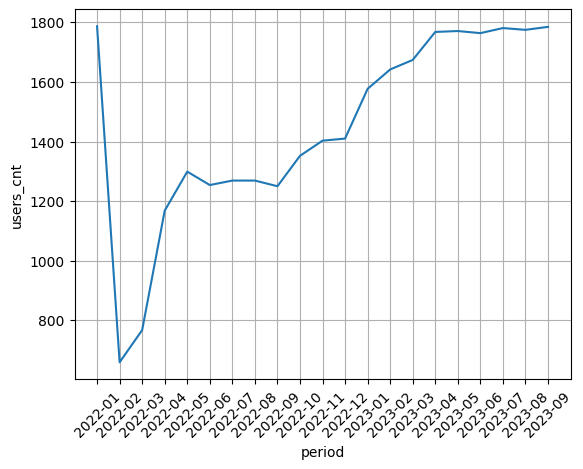

In [ ]:
ca_df = (
    df.groupby(['segment', 'period'], as_index=False).agg({'user_id': pd.Series.nunique})
    .rename(columns={'user_id': 'users_cnt'})
)
ca_df.segment = ca_df.segment.astype(str)
ca_df.period = ca_df.period.astype(str)

# target_segment = ca_df.segment.unique()[-1]
target_segment='2022-01'
ca_df = ca_df[ca_df.segment == target_segment]
sns.lineplot(data=ca_df, x='period', y='users_cnt');
plt.xticks(rotation=45);
plt.grid();
# Верится больше

In [ ]:
# LTV (в тыс, heatmap вдоль столбца)
# Методика расчёта с: https://gopractice.ru/product/how-to-calculate-ltv/

# sum profit
df = get_cohort_analysis(
    df=money_df,
    unit_column='user_id',
    value_column='profit',
    time_column='date',
    metric_func=pd.Series.sum,
    style=False
)
# cumsum profit
num_df = df.cumsum(axis=1)
# users_cnt
den_df = get_cohort_analysis(
    df=money_df,
    unit_column='user_id',
    value_column='user_id',
    time_column='date',
    metric_func=pd.Series.nunique,
    style=False
)[0]
# LTV непосредственно
ltv_df = num_df.div(den_df, axis=0) / 1000
# Визуализация
get_heatmap(
    ltv_df,
    round_val=0,
    gradient_axis=0,
    gradient_min_val=0
)

dt,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
segment,,,,,,,,,,,,,,,,,,,,,
2022-01,3,5,6,9,13,16,19,23,26,30,34,38,44,51,59,70,82,95,109,124,145
2022-02,4,5,8,11,15,18,22,25,29,33,37,43,50,58,69,82,94,109,124,145,nan
2022-03,4,7,10,13,17,20,24,28,32,37,43,50,58,69,82,95,110,125,146,nan,nan
2022-04,4,8,11,14,17,21,24,28,33,39,46,53,65,77,89,104,118,139,nan,nan,nan
2022-05,7,14,21,28,34,41,48,55,62,69,77,86,109,133,158,183,209,nan,nan,nan,nan
2022-06,10,18,26,33,41,48,56,64,71,79,87,114,141,169,197,224,nan,nan,nan,nan,nan
2022-07,11,18,24,32,39,46,55,62,70,79,107,134,162,190,217,nan,nan,nan,nan,nan,nan
2022-08,11,18,27,34,42,50,58,67,74,100,128,152,180,206,nan,nan,nan,nan,nan,nan,nan
2022-09,45,103,158,215,273,324,381,438,497,553,612,671,728,nan,nan,nan,nan,nan,nan,nan,nan


#### Метрики тщеславия

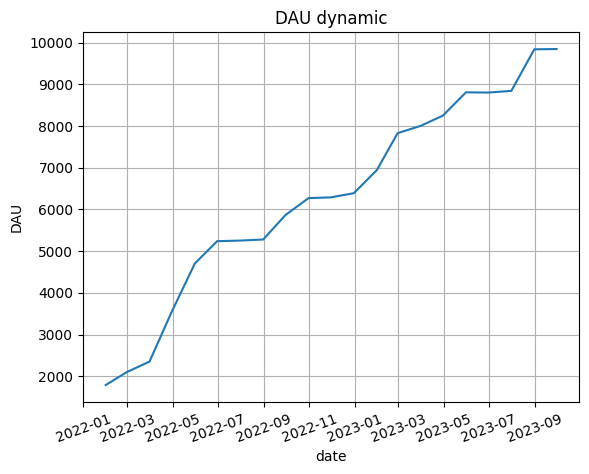

In [ ]:
# DAU
dau_ser = (
    money_df
    .set_index('date').resample('M')
    .user_id.nunique()
    .rename('DAU')
)

metric_name = 'DAU'
sns.lineplot(data=dau_ser);
plt.grid();
plt.xticks(rotation=20);
plt.ylabel(metric_name);
plt.title(metric_name + ' dynamic');

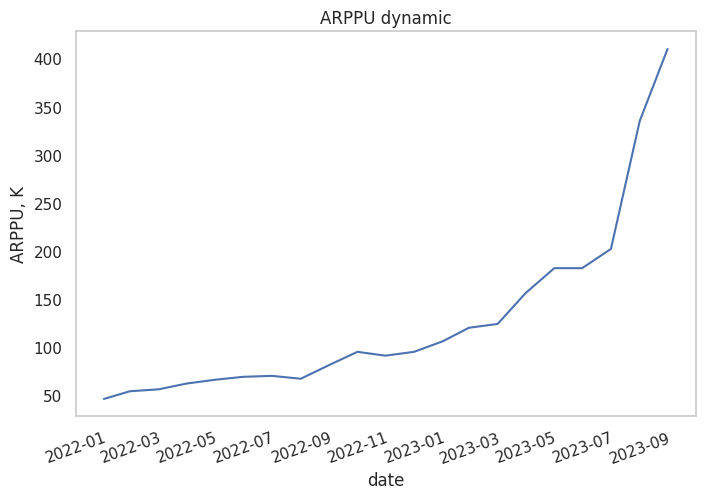

In [ ]:
# ARPPU (тыс)
revenue_ser = (
    money_df
    .set_index('date').resample('M')
    .revenue.sum()
)

arppu_ser = (revenue_ser / dau_ser / 1000).round()

metric_name = 'ARPPU'
sns.lineplot(data=arppu_ser);
plt.grid();
plt.xticks(rotation=20);
plt.ylabel(metric_name + ', K');
plt.title(metric_name + ' dynamic');

#### Дополнительная информация

In [ ]:
# Действующие магазины
store_1_df = store[store.store_close_date.isna()]
store_1_df
# Можно пересчитать по пальцам (с ногами)

,store_id,longtitude,latitude,store_name,store_open_date,store_close_date
0,1,55.790491,37.531373,Aviapark,2023-01-15,NaN
2,3,55.744263,37.565527,Evropeisky,2023-04-01,NaN
3,4,55.692065,37.527865,Kapitoliy Vernadskogo,2023-09-14,NaN
5,6,55.663782,37.511308,Rio Leninsky,2022-01-10,NaN
7,8,56.829106,60.599493,Grinvich,2023-08-05,NaN
8,9,59.927848,30.360482,Galereia,2023-05-01,NaN
9,10,59.987513,30.353777,Evropolis,2022-05-18,NaN
10,11,60.004982,30.298628,City Mall,2023-10-12,NaN
11,12,56.320212,43.947608,Respublica,2023-11-11,NaN
12,13,56.339241,43.956672,Sedmoe Nebo,2023-02-01,NaN


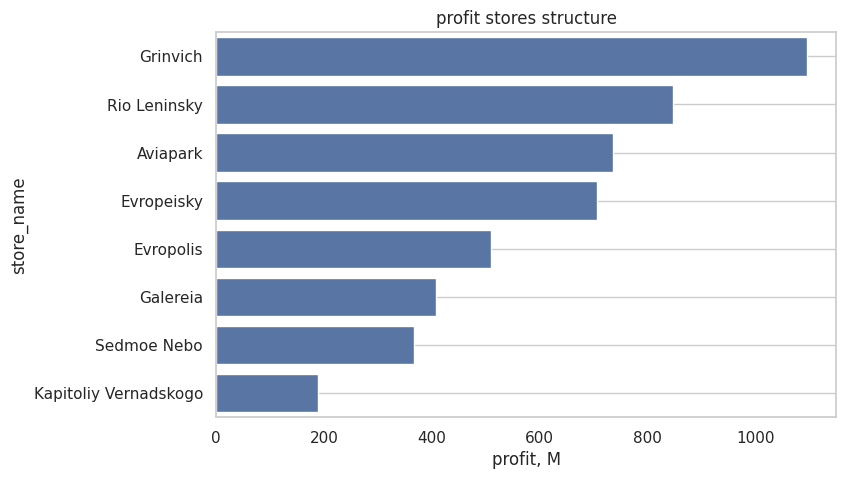

In [ ]:
# Статистика по магазинам
open_stores = store_1_df.store_id.to_numpy()
store_1_stats_df = money_df.query('store_id in @open_stores').groupby('store_id', as_index=False)[['revenue', 'profit']].sum()
store_1_stats_df = (
    store_1_stats_df
    .merge(store_1_df[['store_id', 'store_name']], on='store_id')
    .sort_values('profit', ascending=False)
)
store_1_stats_df
# Открытие некоторых магазинов только планируется / по ним недостаточно статистики

metric_name = 'profit'
sns.barplot(
    x=store_1_stats_df.profit.div(10**6),
    y=store_1_stats_df.store_name
);
plt.grid();
plt.xlabel(metric_name + ', M');
plt.title(f'{metric_name} stores structure');

In [ ]:
# Клиенты

# Приведение типов
user['user_birthdate'] = pd.to_datetime(user['user_birthdate'])
# Фильтрация действующих клиентов
clients = money_df.user_id.unique()
clients_df = user
clients_df = user.query('user_id in @clients and status != "deleted"')
clients_df = clients_df.reset_index(drop=True)
# Добавление полей
clients_df.loc[:, 'city'] = clients_df.user_registration_address.str.split(',').apply(lambda x: x[0])
last_date = money_df.date.max()
clients_df['age'] = ((last_date - clients_df.user_birthdate) / np.timedelta64(1,'Y')).round().astype(int)

# bins = [0, 20, 30, 40, 50, 60, 70, 80, 1000]
# labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
bins = [0, 20, 40, 60, 80, 1000]
labels = ['0-20', '20-40', '40-60', '60-80', '80+']
clients_df['age_group'] = pd.cut(clients_df.age, bins=bins, labels=labels)

# Бреем
clients_df = clients_df[['user_id', 'user_name', 'city', 'age', 'age_group']]

# Информация по выручке, прибыли
clients_df = clients_df.merge(
    money_df.groupby('user_id', as_index=False)[['revenue', 'profit']].sum(),
    on='user_id'
)
clients_df

,user_id,user_name,city,age,age_group,revenue,profit
0,1,Онуфрий Жаринов,Лыткарино,39,20-40,1.490482e+06,574258.756096
1,2,Лола Новгородцева,Тольятти,65,60-80,2.205713e+06,760527.888931
2,3,Фаина Чернева,Калининск,39,20-40,2.237529e+06,764598.009063
3,4,Серафим Берестов,Павлово,36,20-40,1.466763e+06,480061.044956
4,5,Азиза Мухина,Навашино,60,40-60,3.338645e+06,825797.984272
...,...,...,...,...,...,...,...
8639,9995,Гульшат Пророкова,Гурьевск,66,60-80,2.182319e+06,767197.034714
8640,9996,Влада Синявская,Гороховец,71,60-80,2.917492e+06,972983.599079
8641,9998,Иуда Берсенев,Крымск,59,40-60,2.989496e+06,786357.498013
8642,9999,Амира Белоусова,Мантурово,46,40-60,2.971751e+06,992139.391278


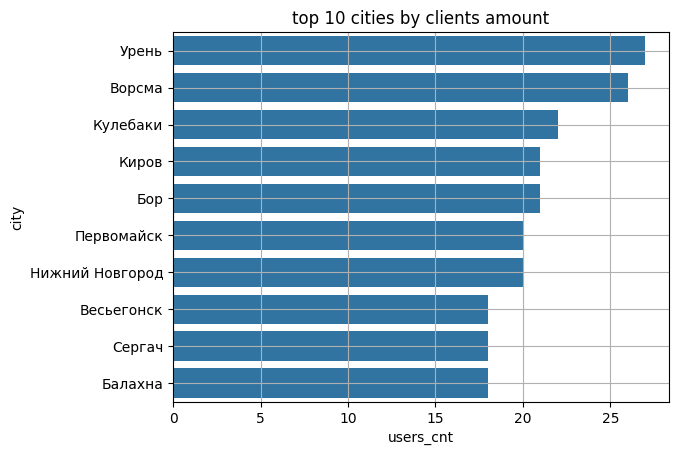

In [ ]:
# Клиенты по городам
metric_name = 'city'
el_n_restriction = 10

sns.barplot(
    data=(
        clients_df.
        groupby(metric_name, as_index=False).user_id.count()
        .rename(columns={'user_id': 'users_cnt'})
        .sort_values('users_cnt', ascending=False)
        .head(el_n_restriction)
    ),
    x='users_cnt',
    y=metric_name
);
plt.grid();
plt.title(f'top {el_n_restriction} cities by clients amount');

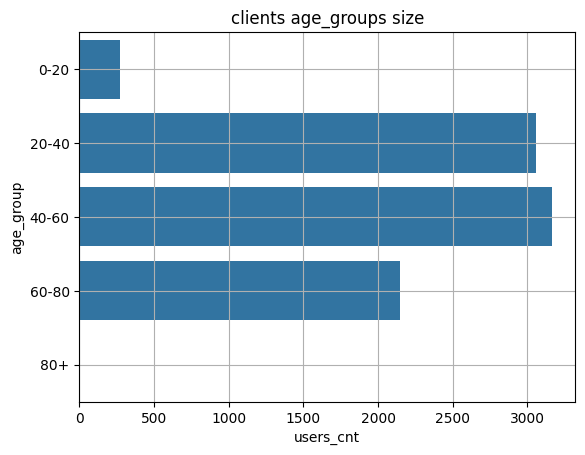

In [ ]:
# Клиенты по возрастным группам

metric_name = 'age_group'
sns.barplot(
    data=(
        clients_df.
        groupby(metric_name, as_index=False).user_id.count()
        .rename(columns={'user_id': 'users_cnt'})
        .sort_values('users_cnt', ascending=False)
    ),
    x='users_cnt',
    y=metric_name
);
plt.grid();
plt.title(f'clients {metric_name}s size');

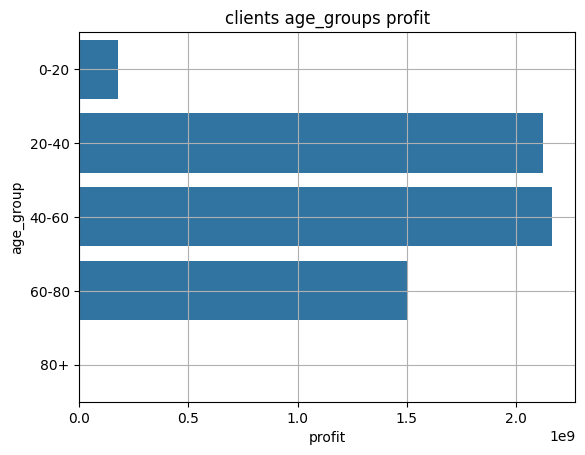

In [ ]:
# Прибыль с клиентов по возрастным группам

metric_name = 'age_group'
sns.barplot(
    data=(
        clients_df.
        groupby(metric_name, as_index=False).profit.sum()
        .sort_values('profit', ascending=False)
    ),
    x='profit',
    y=metric_name
);
plt.grid();
plt.title(f'clients {metric_name}s profit');

#### Итог

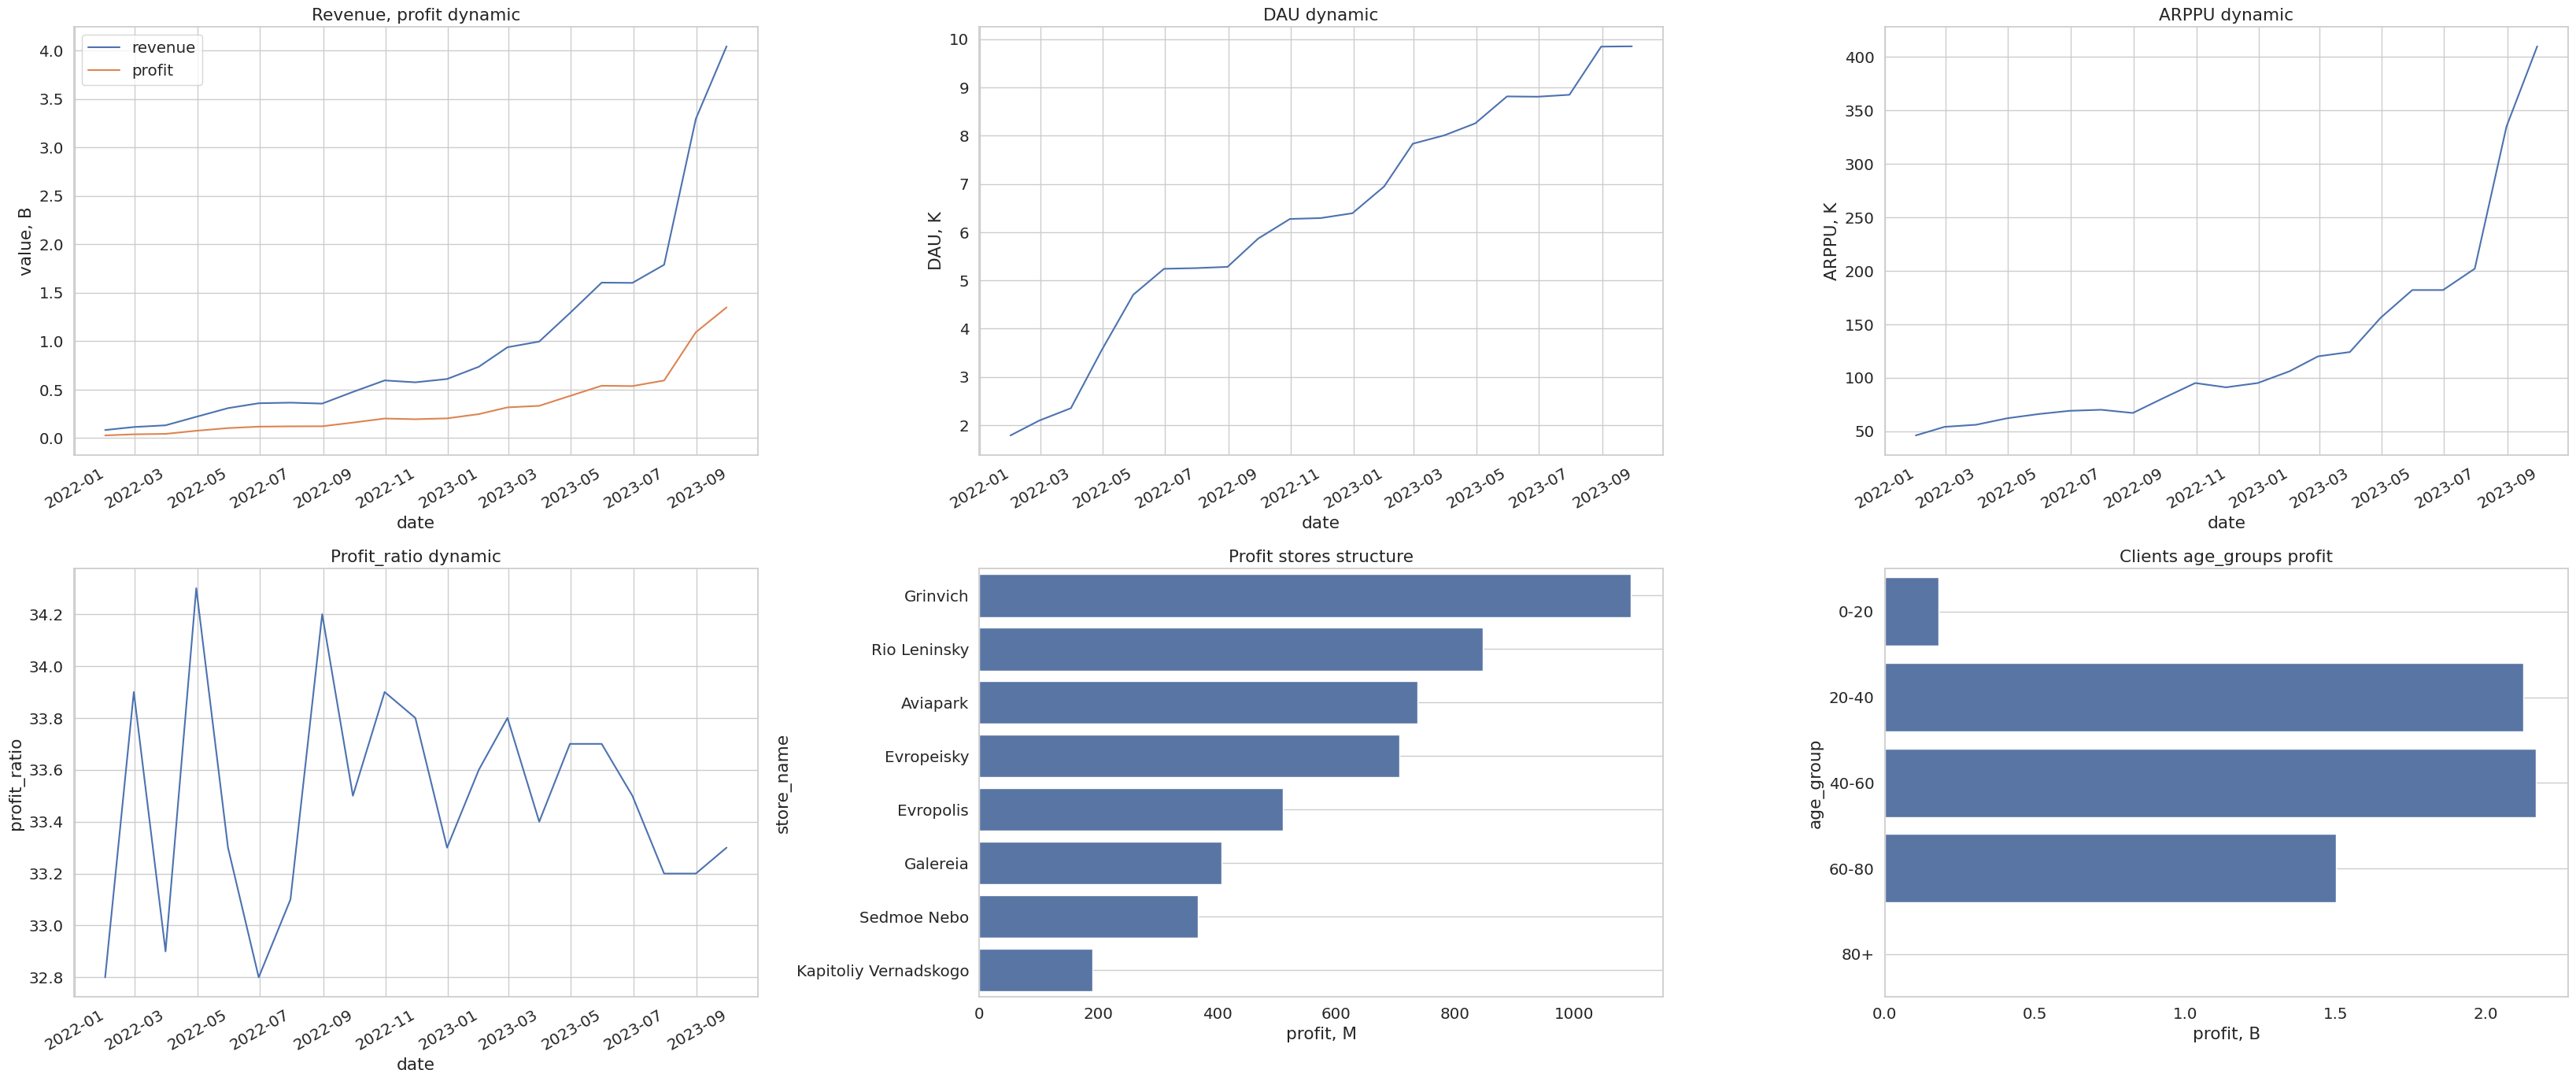


customer_retension (heatmap вдоль строки):


dt,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
segment,,,,,,,,,,,,,,,,,,,,,
2022-01,100,37,43,65,73,70,71,71,70,76,79,79,88,92,94,99,99,99,100,99,100
2022-02,100,42,65,71,70,71,72,70,77,78,79,89,91,93,98,99,99,100,100,100,nan
2022-03,100,62,69,72,70,71,71,76,78,79,89,92,93,99,98,99,99,100,100,nan,nan
2022-04,100,72,69,69,70,69,78,76,79,90,92,94,99,99,99,100,100,100,nan,nan,nan
2022-05,100,73,72,73,70,74,71,73,75,77,77,78,99,99,99,99,98,nan,nan,nan,nan
2022-06,100,71,71,69,73,69,71,73,71,76,73,98,99,99,99,99,nan,nan,nan,nan,nan
2022-07,100,67,66,72,69,69,76,67,75,75,99,98,99,100,99,nan,nan,nan,nan,nan,nan
2022-08,100,75,71,70,79,69,76,74,74,99,99,99,99,99,nan,nan,nan,nan,nan,nan,nan
2022-09,100,99,98,98,99,98,99,99,100,99,100,100,100,nan,nan,nan,nan,nan,nan,nan,nan



LTV (в тыс, heatmap вдоль столбца):


dt,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
segment,,,,,,,,,,,,,,,,,,,,,
2022-01,3,5,6,9,13,16,19,23,26,30,34,38,44,51,59,70,82,95,109,124,145
2022-02,4,5,8,11,15,18,22,25,29,33,37,43,50,58,69,82,94,109,124,145,nan
2022-03,4,7,10,13,17,20,24,28,32,37,43,50,58,69,82,95,110,125,146,nan,nan
2022-04,4,8,11,14,17,21,24,28,33,39,46,53,65,77,89,104,118,139,nan,nan,nan
2022-05,7,14,21,28,34,41,48,55,62,69,77,86,109,133,158,183,209,nan,nan,nan,nan
2022-06,10,18,26,33,41,48,56,64,71,79,87,114,141,169,197,224,nan,nan,nan,nan,nan
2022-07,11,18,24,32,39,46,55,62,70,79,107,134,162,190,217,nan,nan,nan,nan,nan,nan
2022-08,11,18,27,34,42,50,58,67,74,100,128,152,180,206,nan,nan,nan,nan,nan,nan,nan
2022-09,45,103,158,215,273,324,381,438,497,553,612,671,728,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
# Статичный дашборд
# Лучше, конечно, было использовать что-то вроде https://habr.com/ru/companies/otus/articles/716190/
# * Код с доставанием данных не вставлял, чтобы было меньше дублирования

# Параметры графиков
sns.set(
  font_scale=1.3,  # Размер шрифта
  style='whitegrid',  # Стиль задника, осей
  rc={'figure.figsize': (8, 5)}  # Размер диаграммы
)
# Параметры полотна
# Количество графиков
n = 2  # Строки
m = 3  # Столбцы
# Размер графиков
n_scale = 7  # Высота
m_scale = 11  # Длина
# Расчёты
size = (n, m)
figsize = (m_scale*size[1], n_scale*size[0])
fig, ax = plt.subplots(*size, figsize=figsize)

# Графики

plt.subplot(n, 3, 1);
# Динамика revenue, profit
metrics = ['revenue', 'profit']
for metric in metrics:
  sns.lineplot(data=money_month_df, x='date', y=money_month_df[metric]/10**9, label=metric);
plt.xticks(rotation=30);
plt.ylabel('value, B');
plt.title('Revenue, profit dynamic');

plt.subplot(n, 3, 2);
# DAU (тыс)
metric_name = 'DAU'
sns.lineplot(data=dau_ser/1000);
plt.xticks(rotation=30);
plt.ylabel(f'{metric_name}, K');
plt.title(metric_name + ' dynamic');

plt.subplot(n, 3, 3);
# ARPPU (тыс)
metric_name = 'ARPPU'
sns.lineplot(data=arppu_ser);
plt.xticks(rotation=30);
plt.ylabel(metric_name + ', K');
plt.title(metric_name + ' dynamic');

plt.subplot(n, 3, 4);
# Динамика profit_ratio
metric_name = 'profit_ratio'
sns.lineplot(data=money_month_df, x='date', y=metric_name);
plt.xticks(rotation=30);
plt.ylabel(metric_name);
plt.title(f'{metric_name.capitalize()} dynamic');

ax = plt.subplot(n, 3, 5);
# Статистика по магазинам
metric_name = 'profit'
sns.barplot(
    x=store_1_stats_df.profit.div(10**6),
    y=store_1_stats_df.store_name
    , ax=ax
);
plt.grid();
plt.xlabel(metric_name + ', M');
plt.title(f'{metric_name.capitalize()} stores structure');

plt.subplot(n, 3, 6);
# Прибыль с клиентов по возрастным группам
metric_name = 'age_group'
age_group_profit_df = (
    clients_df.
    groupby(metric_name, as_index=False).profit.sum()
    .sort_values('profit', ascending=False)
)
sns.barplot(
    data=age_group_profit_df,
    x=age_group_profit_df['profit']/10**9,
    y=metric_name
);
plt.grid();
plt.xlabel('profit, B')
plt.title(f'Clients {metric_name}s profit');

fig.tight_layout()
plt.show()

# customer_retension (heatmap вдоль строки)
print('\ncustomer_retension (heatmap вдоль строки):')
ca_style_df = get_cohort_analysis(
    df=money_df,
    unit_column='user_id',
    value_column='order_id',
    time_column='date',
    metric_func=pd.Series.nunique,
    normalize=True,
    percents=True,
    round_val=0
)
display(ca_style_df)

# LTV (в тыс, heatmap вдоль столбца)
# Методика расчёта с: https://gopractice.ru/product/how-to-calculate-ltv/
print('\nLTV (в тыс, heatmap вдоль столбца):')
ltv_style_df = get_heatmap(
    ltv_df,
    round_val=0,
    gradient_axis=0,
    gradient_min_val=0
)
display(ltv_style_df)

### Решение 3.2.

#### Разведочный анализ

In [ ]:
query = """
WITH
  orders_fix_t AS (
    -- Пофикшены данные bool типа и кавычки для столбца product_info (для json)
    SELECT
      order_id, order_date, user_id, store_id,
      REPLACE(
        REPLACE(
          REPLACE(product_info
            , 'True', '1')
            ,  'False', '0')
            , '''', '"') AS product_info
    FROM orders
  ),
  orders_products_t AS (
    -- Информация по продуктам в заказах
    -- * Есть странные товары с product_price == 0
    -- * Есть странные товары с product_price == 0, comission_is_percent == 0, product_comission > 0
    SELECT
      order_id, order_date, user_id, store_id,
      json_extract(pi.value, '$.product_id') AS product_id,
      json_extract(pi.value, '$.product_price') AS product_price,
      json_extract(pi.value, '$.product_comission') AS product_comission,
      json_extract(pi.value, '$.comission_is_percent') AS comission_is_percent,
      json_extract(pi.value, '$.count') AS count
    FROM
      orders_fix_t,
      JSON_EACH(product_info) AS pi
  ),
  sales_sx_t AS (
    -- Выкупленные продукты в заказах
    SELECT *
    FROM sales
    WHERE
      is_accepted = 1
      AND is_canceled = 0
  ),
  products_sx_t AS (
    -- Выкупленные продукты в заказах с информацией по ним
    -- * Значений больше, чем в sales_sx_t (тк в orders_products_t есть повторения по order_id, product_id (например, из-за разной комиссии))
    -- Дополнительно:
    -- - profit_per_1 - прибыль с единицы товара
    SELECT
      l.order_id, l.product_id, order_date, user_id, product_price, product_comission, comission_is_percent, count, store_id,
      CASE comission_is_percent
        WHEN 1 THEN product_price * product_comission / 100
        WHEN 0 THEN product_comission
      END AS profit_per_1
    FROM orders_products_t AS l
      JOIN sales_sx_t AS r
      ON l.order_id = r.order_id
      AND l.product_id = r.product_id
  ),
  products_t AS (
    -- Информация по позициям в заказе
    SELECT
      store_id,
      order_date AS date,
      product_id,
      SUM(count) AS count
    FROM products_sx_t
    GROUP BY
      store_id,
      order_date,
      product_id
  )

SELECT *
FROM products_t
"""

orders_products_df = sqldf(query)
orders_products_df

,store_id,date,product_id,count
0,1,2023-01-16,7,1
1,1,2023-01-16,25,1
2,1,2023-01-16,31,1
3,1,2023-01-16,37,1
4,1,2023-01-16,41,1
...,...,...,...,...
1244768,15,2023-10-09,3669,1
1244769,15,2023-10-09,3673,1
1244770,15,2023-10-09,3697,1
1244771,15,2023-10-09,3704,1


In [ ]:
# df для измений
purchased_products_df = orders_products_df.copy()
purchased_products_df.date = pd.to_datetime(purchased_products_df.date)
purchased_products_df['month'] = purchased_products_df.date.dt.to_period('M')
purchased_products_df.dtypes

store_id               int64
date          datetime64[ns]
product_id             int64
count                  int64
month              period[M]
dtype: object

In [ ]:
last_date = purchased_products_df.date.max()
last_date

Timestamp('2023-10-10 00:00:00')

In [ ]:
last_month = purchased_products_df.month.max()
last_month

Period('2023-10', 'M')

Для возможности прогноза на 2 мес требуется:
- магазин открыт
- имеются данные хотя бы за 8 предыдущих месяцев => с 2023-02 включительно
  - при этом если магазин открыт с этого времени, то не факт, что некоторый товар продаётся с самого начала => это необходимое, но не достаточное условие

In [ ]:
open_stores_df = store[store.store_close_date.isna()].sort_values('store_open_date', ascending=False).reset_index(drop=True)
open_stores_df

,store_id,longtitude,latitude,store_name,store_open_date,store_close_date
0,12,56.320212,43.947608,Respublica,2023-11-11,NaN
1,11,60.004982,30.298628,City Mall,2023-10-12,NaN
2,14,56.287358,43.928319,Muravei,2023-10-03,NaN
3,4,55.692065,37.527865,Kapitoliy Vernadskogo,2023-09-14,NaN
4,8,56.829106,60.599493,Grinvich,2023-08-05,NaN
5,9,59.927848,30.360482,Galereia,2023-05-01,NaN
6,3,55.744263,37.565527,Evropeisky,2023-04-01,NaN
7,13,56.339241,43.956672,Sedmoe Nebo,2023-02-01,NaN
8,1,55.790491,37.531373,Aviapark,2023-01-15,NaN
9,10,59.987513,30.353777,Evropolis,2022-05-18,NaN


Направления деятельности магазинов:
- ТЦ
  - в прошлом задании появился владелец для всех ТЦ? :\

\
Корректный прогноз сделать не получится:
- Respublica - открытие планируется (2023-11-11), нет данных для прогноза
- City Mall - открытие планируется (2023-10-12), нет данных для прогноза
- Muravei - недостаточно статистики для прогноза (открыт 2023-10-03)
- Kapitoliy Vernadskogo - недостаточно статистики для прогноза (открыт 2023-09-14)
- Grinvich - недостаточно статистики для прогноза (открыт 2023-08-05)

Можно сделать неточный прогноз:
- Galereia - недостаточно статистики для прогноза (открыт 2023-05-01)
- Evropeisky - недостаточно статистики для прогноза (открыт 2023-04-01)

Возможен корректный прогноз (4 из 11):
- Sedmoe Nebo
- Aviapark
- Evropolis
- Rio Leninsky

\
Города, где расположены магазины:
- Rio Leninsky (мск) +
- Aviapark (мск) +
- Evropeisky (мск) ~
- Kapitoliy Vernadskogo (мск) -


- Evropolis (спб) +
- Galereia (спб) ~
- City Mall (спб) --


- Sedmoe Nebo (нн) +
- Muravei (нн) -
- Respublica (нн) --


- Grinvich (екб) -

In [ ]:
# Фильтрация по открытым магазинам
purchased_products_df = purchased_products_df.merge(open_stores_df[['store_id', 'store_name']], on='store_id')
purchased_products_df = purchased_products_df.merge(product[['product_id', 'product_name']], on='product_id')
purchased_products_df

,store_id,date,product_id,count,month,store_name,product_name
0,1,2023-01-16,7,1,2023-01,Aviapark,Azure Bliss Jeans
1,1,2023-01-17,7,1,2023-01,Aviapark,Azure Bliss Jeans
2,1,2023-01-21,7,1,2023-01,Aviapark,Azure Bliss Jeans
3,1,2023-02-02,7,1,2023-02,Aviapark,Azure Bliss Jeans
4,1,2023-02-07,7,1,2023-02,Aviapark,Azure Bliss Jeans
...,...,...,...,...,...,...,...
869394,13,2023-09-28,3220,1,2023-09,Sedmoe Nebo,Pinnacle Plaid Polo
869395,13,2023-09-30,3220,1,2023-09,Sedmoe Nebo,Pinnacle Plaid Polo
869396,14,2023-10-04,3220,1,2023-10,Muravei,Pinnacle Plaid Polo
869397,14,2023-10-05,3220,1,2023-10,Muravei,Pinnacle Plaid Polo


In [ ]:
# Топ по проданным продуктам
purchased_products_df.groupby('store_name', as_index=False)['count'].sum().sort_values('count', ascending=False).reset_index(drop=True)

,store_name,count
0,Grinvich,277872
1,Rio Leninsky,186208
2,Aviapark,166293
3,Evropeisky,160906
4,Evropolis,113152
5,Galereia,94519
6,Sedmoe Nebo,83414
7,Kapitoliy Vernadskogo,65293
8,Muravei,11062


- Grinvich (0) - не спрогнозировать, но прогноз важен
- Rio Leninsky (1), Aviapark (2), Evropolis (4), Sedmoe Nebo (6) - можно нормально спрогнозировать
- Evropeisky (3), Galereia (5)  - можно примерно спрогногзировать
Kapitoliy Vernadskogo (7), Muravei (8) - не спрогнозировать

* Для Muravei данные лишь за ~ неделю - прогноз на 2 месяца вперёд имхо невозможен

In [ ]:
# Магазины, по которым можно построить прогноз в общем виде
stores_base = open_stores_df.store_name.tail(6)
prod_base_df = purchased_products_df[purchased_products_df.store_name.isin(stores_base)]
prod_base_df.store_name.unique()

array(['Aviapark', 'Evropeisky', 'Rio Leninsky', 'Galereia', 'Evropolis',
       'Sedmoe Nebo'], dtype=object)

In [ ]:
# Магазины, которые стоит рассматривать в индивидуальном порядке
stores_uniq = ('Grinvich', 'Kapitoliy Vernadskogo')
prod_uniq_df = purchased_products_df[purchased_products_df.store_name.isin(stores_uniq)]
prod_uniq_df.store_name.unique()

array(['Kapitoliy Vernadskogo', 'Grinvich'], dtype=object)

In [ ]:
# Магазины, по которым не получится произвести прогноз
stores_drop = ('Muravei', )
prod_drop_df = purchased_products_df[purchased_products_df.store_name.isin(stores_drop)]
prod_drop_df.store_name.unique()

array(['Muravei'], dtype=object)

#### Прогноз по магазинам, где это можно сделать в общем виде

In [ ]:
last_month = purchased_products_df.month.max()
last_month

Period('2023-10', 'M')

In [ ]:
# Убираем последний месяц (недостаточно информации)
prod_base_df = prod_base_df[prod_base_df.month < last_month]
prod_base_df = prod_base_df.reset_index(drop=True)
prod_base_df.date.max()

Timestamp('2023-09-30 00:00:00')

In [ ]:
prod_base_df = prod_base_df.groupby(['store_name', 'month', 'product_id', 'product_name'], as_index=False)['count'].sum()
prod_base_df

,store_name,month,product_id,product_name,count
0,Aviapark,2023-01,1,Azure Bliss Jeans,2
1,Aviapark,2023-01,2,Azure Bliss Jeans,1
2,Aviapark,2023-01,3,Azure Bliss Jeans,5
3,Aviapark,2023-01,4,Azure Bliss Jeans,3
4,Aviapark,2023-01,5,Azure Bliss Jeans,3
...,...,...,...,...,...
216204,Sedmoe Nebo,2023-09,3715,Onyx Odyssey Onesie,2
216205,Sedmoe Nebo,2023-09,3716,Onyx Odyssey Onesie,2
216206,Sedmoe Nebo,2023-09,3718,Onyx Odyssey Onesie,5
216207,Sedmoe Nebo,2023-09,3719,Onyx Odyssey Onesie,2


In [ ]:
# Необходимо сделать прогнозов
prod_base_df.groupby(['store_name', 'product_id'], as_index=False)['count'].count().shape[0]
# Достаточно много

22098

- Rio Leninsky (мск) +
- Aviapark (мск) +
- Evropeisky (мск) ~
- Evropolis (спб) +
- Galereia (спб) ~
- Sedmoe Nebo (нн) +

In [ ]:
# Уникальные товары
print('Количество уникальных товаров по магазинам:')
for store_name in prod_base_df.store_name.unique():
  print(f'- {store_name}:\t{prod_base_df[prod_base_df.store_name == store_name].product_id.nunique()}')
# Интересно, что в магазинах одинаковое количество уникальных товаров

Количество уникальных товаров по магазинам:
- Aviapark:	3683
- Evropeisky:	3683
- Evropolis:	3683
- Galereia:	3683
- Rio Leninsky:	3683
- Sedmoe Nebo:	3683


In [ ]:
# Совпадения по количеству товаров
stores_list = prod_base_df.store_name.unique()

for i in range(len(stores_list)):
  store_fix = stores_list[i]
  store_fix_products = prod_base_df[prod_base_df.store_name == store_fix].product_id.sort_values().unique()
  print(f'{store_fix}:')
  for store_name in stores_list[i+1:]:
    print(f"""   {np.sum(
        store_fix_products
        ==prod_base_df[prod_base_df.store_name == store_name].product_id.sort_values().unique()
        )} ~ {store_name}"""
    )
# => Во всех магазинах продаются одни и те же товары

Aviapark:
   3683 ~ Evropeisky
   3683 ~ Evropolis
   3683 ~ Galereia
   3683 ~ Rio Leninsky
   3683 ~ Sedmoe Nebo
Evropeisky:
   3683 ~ Evropolis
   3683 ~ Galereia
   3683 ~ Rio Leninsky
   3683 ~ Sedmoe Nebo
Evropolis:
   3683 ~ Galereia
   3683 ~ Rio Leninsky
   3683 ~ Sedmoe Nebo
Galereia:
   3683 ~ Rio Leninsky
   3683 ~ Sedmoe Nebo
Rio Leninsky:
   3683 ~ Sedmoe Nebo
Sedmoe Nebo:


Авторский вариант для снижения количества прогнозов в этой ситуации (мб получится даже снизить суммарную ошибку и упростить модель, а мб получится шляпа :) ):
- объединить данные по продажам товаров во всех магазинах
- сделать прогноз по товару (на данных из всех магазинов)
- распределить спрогнозированные значения в соответствии с распределением количества товаров в последний месяц с доступными данными

In [ ]:
prod_base_df

,store_name,month,product_id,product_name,count
0,Aviapark,2023-01,1,Azure Bliss Jeans,2
1,Aviapark,2023-01,2,Azure Bliss Jeans,1
2,Aviapark,2023-01,3,Azure Bliss Jeans,5
3,Aviapark,2023-01,4,Azure Bliss Jeans,3
4,Aviapark,2023-01,5,Azure Bliss Jeans,3
...,...,...,...,...,...
216204,Sedmoe Nebo,2023-09,3715,Onyx Odyssey Onesie,2
216205,Sedmoe Nebo,2023-09,3716,Onyx Odyssey Onesie,2
216206,Sedmoe Nebo,2023-09,3718,Onyx Odyssey Onesie,5
216207,Sedmoe Nebo,2023-09,3719,Onyx Odyssey Onesie,2


In [ ]:
# Объединение данных по продаже товаров
data_base_df = prod_base_df.groupby(['month', 'product_id', 'product_name'], as_index=False)['count'].sum()
data_base_df

,month,product_id,product_name,count
0,2022-01,1,Azure Bliss Jeans,1
1,2022-01,2,Azure Bliss Jeans,1
2,2022-01,3,Azure Bliss Jeans,2
3,2022-01,4,Azure Bliss Jeans,2
4,2022-01,5,Azure Bliss Jeans,2
...,...,...,...,...
74163,2023-09,3716,Onyx Odyssey Onesie,22
74164,2023-09,3717,Onyx Odyssey Onesie,48
74165,2023-09,3718,Onyx Odyssey Onesie,19
74166,2023-09,3719,Onyx Odyssey Onesie,49


In [ ]:
# Сколько дат пропущено
data_base_df.product_id.nunique() * data_base_df.month.nunique() - data_base_df.shape[0]

3175

In [ ]:
# Уникальные минимальные даты по товарам
data_base_df.groupby('product_id', as_index=False).month.min().month.value_counts()
# => даты пропущены не только из-за сдвига минимальной даты
# При этом есть гарантия, что для всех продуктов достаточно данных для прогнозирования

month
2022-01    2819
2022-02     737
2022-03     112
2022-04      15
Freq: M, Name: count, dtype: int64

In [ ]:
last_month = data_base_df.month.max()
last_month

Period('2023-09', 'M')

In [ ]:
# Все месяцы по продуктам
min_months_df = (
    data_base_df.groupby('product_id', as_index=False).month.min()
    .rename(columns={'month': 'min_month'})
)
months_df = min_months_df.copy()
months_df['month'] = min_months_df.min_month.apply(lambda start: pd.period_range(start=start, end=last_month))
months_df = months_df.explode('month', ignore_index=True).drop('min_month', axis=1)
months_df

,product_id,month
0,1,2022-01
1,1,2022-02
2,1,2022-03
3,1,2022-04
4,1,2022-05
...,...,...
76332,3720,2023-05
76333,3720,2023-06
76334,3720,2023-07
76335,3720,2023-08


In [ ]:
# Вся информация и все месяцы
data_base_df = months_df.merge(data_base_df, how='left', on=['product_id', 'month'])
data_base_df['count'] = data_base_df['count'].fillna(0)
data_base_df['date'] = pd.to_datetime(data_base_df.month.astype(str))
data_base_df

,product_id,month,product_name,count,date
0,1,2022-01,Azure Bliss Jeans,1.0,2022-01-01
1,1,2022-02,Azure Bliss Jeans,1.0,2022-02-01
2,1,2022-03,Azure Bliss Jeans,3.0,2022-03-01
3,1,2022-04,Azure Bliss Jeans,2.0,2022-04-01
4,1,2022-05,Azure Bliss Jeans,3.0,2022-05-01
...,...,...,...,...,...
76332,3720,2023-05,Onyx Odyssey Onesie,28.0,2023-05-01
76333,3720,2023-06,Onyx Odyssey Onesie,29.0,2023-06-01
76334,3720,2023-07,Onyx Odyssey Onesie,16.0,2023-07-01
76335,3720,2023-08,Onyx Odyssey Onesie,25.0,2023-08-01


In [ ]:
data_base_df.product_name.isna().sum()

2169

In [ ]:
# Проверка
data_base_df['count'].isna().sum()

0

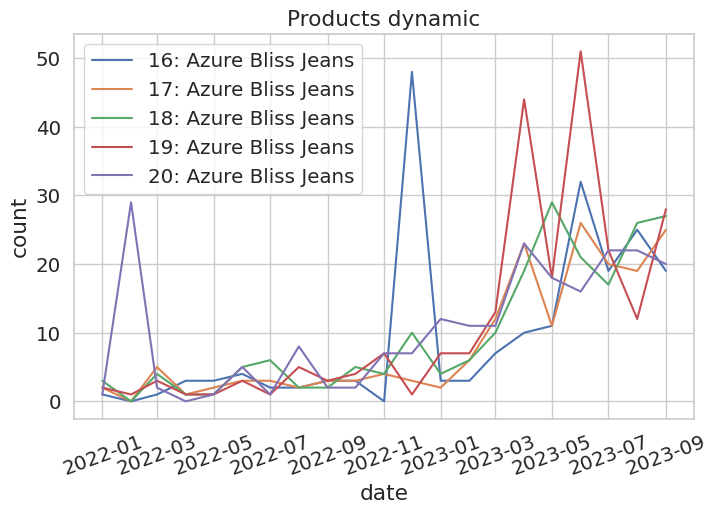

In [ ]:
# Динамика товаров
start_i = 15
end_i   = 20

for id in data_base_df.product_id.unique()[start_i:end_i]:
  sns.lineplot(
      data=data_base_df[data_base_df.product_id == id],
      x='date',
      y='count',
      label=f'{id}: {data_base_df[data_base_df.product_id == id].product_name.iloc[0]}'
  );
plt.title('Products dynamic')
# plt.grid();
plt.xticks(rotation=20);

# Требования для обычной одномерной регрессии в общем случае выполняться не будут

In [ ]:
!pip install orbit-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.9/446.9 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using

In [ ]:
import orbit # Общий пакет для прогнозирования
from orbit.models import DLT # Один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components # Для рисования предсказаний

Тут должен был быть выбор оптимальной модели. С выбором train-test split или бэктестингом

Для точности лучше было бы выбрать оценку коэффициентов по MCMC (но это заняло бы больше времени + не получилось бы проверить сходимость)

*Мб хватило бы оценки сверху - найти максимум временного ряда, взять коэффициент запаса

Берём 95-й процентиль с коэффициентом запаса для перестраховки (особенно с учётом низкой точности для ДИ)

In [ ]:
start_i = 0
end_i   = data_base_df.shape[0]

forecast_horizon = 2  # Количество месяцев для прогнозирования
reserve_k = 1.1  # Коэффициент запаса

data_res_df = data_base_df.copy()
# Можно добавить tqdm
for i, id in enumerate(data_base_df.product_id.unique()[start_i:end_i]):
  df = data_base_df[data_base_df.product_id == id]

  metric = "count"
  time = "date"

  model = DLT(
      response_col=metric, #  Колонка с метрикой
      date_col=time,  # Колонка с временем
      seasonality=12, # Сезонность
      estimator="stan-map", # Оценщик
      n_bootstrap_draws=1000,  # Число бутстрап-выборок для ДИ
  )

  model.fit(df);

  future_df = model.make_future_df(periods=forecast_horizon);

  predicted_df = model.predict(df=future_df);

  add_df = predicted_df[['date', 'prediction_95']].rename(columns={'prediction_95': 'count'})
  add_df['count'] = add_df['count'].where(add_df['count'] >= 0, 0).mul(reserve_k).apply(np.ceil)
  add_df['product_id'] = df['product_id'].iloc[0]
  add_df['month'] = df['month'].iloc[0]
  add_df['product_name'] = df['product_name'].iloc[0]

  data_res_df = pd.concat([data_res_df, add_df], ignore_index=True)

  if i == 0:
    next_month_df = add_df.tail(1)
  else:
    next_month_df = pd.concat([next_month_df, add_df.tail(1)], ignore_index=True)

  print(f'iteration: {i}')

Streaming output truncated to the last 5000 lines.
2024-05-30 23:55:31 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-05-30 23:55:32 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-05-30 23:55:32 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-05-30 23:55:32 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-05-30 23:55:33 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-05-30 23:55:33 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (CmdStanPy) with algorithm: LBFGS.
2024-05-30 23:55:33 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
INFO:orbit:Optimizing (Cmd

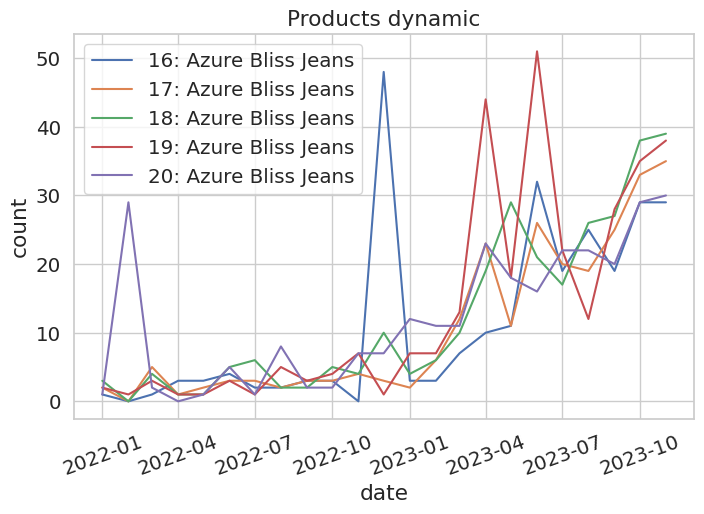

In [ ]:
# Динамика товаров
start_i = 15
end_i   = 20

for id in data_res_df.product_id.unique()[start_i:end_i]:
  sns.lineplot(
      data=data_res_df[data_res_df.product_id == id],
      x='date',
      y='count',
      label=f'{id}: {data_res_df[data_res_df.product_id == id].product_name.iloc[0]}'
  );
plt.title('Products dynamic')
# plt.grid();
plt.xticks(rotation=20);

In [ ]:
# Сохраняем, чтобы не ждать в следующий раз
data_res_df.to_csv('data_res_df.csv', index=False)
next_month_df.to_csv('next_month_df.csv', index=False)

In [ ]:
# Загружаем данные с предсказаниями с GDrive
urls = (
    'https://drive.google.com/file/d/1iTGx4nfm22XDcvb0oiOVp5-JEp8flxAW/view?usp=sharing',  # data_res_df.csv
    'https://drive.google.com/file/d/1qS09nsZSvxHo87p9iSdLCPol8XyIyiXq/view?usp=sharing'   # next_month_df.csv
)
for url in urls:
  url = f'https://drive.google.com/uc?export=download&id={url[32:65]}'
  gdown.download(url)

data_res_df = pd.read_csv('data_res_df.csv')
next_month_df = pd.read_csv('next_month_df.csv')

# Приведение типов
data_res_df['month'] = pd.to_datetime(data_res_df['month']).dt.to_period('M')
data_res_df['date'] = pd.to_datetime(data_res_df['date'])
next_month_df['month'] = pd.to_datetime(next_month_df['month']).dt.to_period('M')
next_month_df['date'] = pd.to_datetime(next_month_df['date'])

Downloading...
From: https://drive.google.com/uc?export=download&id=1iTGx4nfm22XDcvb0oiOVp5-JEp8flxAW
To: /content/data_res_df.csv
100%|██████████| 4.23M/4.23M [00:00<00:00, 216MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1qS09nsZSvxHo87p9iSdLCPol8XyIyiXq
To: /content/next_month_df.csv
100%|██████████| 191k/191k [00:00<00:00, 65.1MB/s]


In [ ]:
next_month_df['month'] = next_month_df.date.dt.to_period('M')
next_month_df = next_month_df.rename(columns={'count': 'count_sum'})
next_month_df

,date,count_sum,product_id,month,product_name
0,2023-11-01,27.0,1,2023-11,Azure Bliss Jeans
1,2023-11-01,30.0,2,2023-11,Azure Bliss Jeans
2,2023-11-01,22.0,3,2023-11,Azure Bliss Jeans
3,2023-11-01,27.0,4,2023-11,Azure Bliss Jeans
4,2023-11-01,31.0,5,2023-11,Azure Bliss Jeans
...,...,...,...,...,...
3678,2023-11-01,32.0,3716,2023-11,Onyx Odyssey Onesie
3679,2023-11-01,50.0,3717,2023-11,Onyx Odyssey Onesie
3680,2023-11-01,29.0,3718,2023-11,Onyx Odyssey Onesie
3681,2023-11-01,52.0,3719,2023-11,Onyx Odyssey Onesie


In [ ]:
# Количество товаров по магазинам в последний месяц
last_month_df = prod_base_df.drop('product_name', axis=1).sort_values(['store_name', 'product_id']).groupby(['store_name', 'product_id',], as_index=False).tail(1)
last_month = last_month_df.month.max()
last_month_dum_df = last_month_df.copy().drop('count', axis=1)
last_month_dum_df['month'] = last_month
last_month_df = last_month_df.merge(last_month_dum_df, how='right', on=['store_name', 'product_id', 'month'])
last_month_df['count'] = last_month_df['count'].fillna(0)
last_month_df

,store_name,month,product_id,count
0,Aviapark,2023-09,1,5.0
1,Aviapark,2023-09,2,2.0
2,Aviapark,2023-09,3,3.0
3,Aviapark,2023-09,4,7.0
4,Aviapark,2023-09,5,2.0
...,...,...,...,...
22093,Sedmoe Nebo,2023-09,3716,2.0
22094,Sedmoe Nebo,2023-09,3717,0.0
22095,Sedmoe Nebo,2023-09,3718,5.0
22096,Sedmoe Nebo,2023-09,3719,2.0


In [ ]:
# Добавляем новый столбец
last_month_df = last_month_df.merge(
    last_month_df.groupby('product_id', as_index=False)['count'].sum().rename(columns={'count': 'count_sum_data'}),
    how='left',
    on='product_id'
)
last_month_df

,store_name,month,product_id,count,count_sum_data
0,Aviapark,2023-09,1,5.0,15.0
1,Aviapark,2023-09,2,2.0,18.0
2,Aviapark,2023-09,3,3.0,15.0
3,Aviapark,2023-09,4,7.0,19.0
4,Aviapark,2023-09,5,2.0,13.0
...,...,...,...,...,...
22093,Sedmoe Nebo,2023-09,3716,2.0,22.0
22094,Sedmoe Nebo,2023-09,3717,0.0,48.0
22095,Sedmoe Nebo,2023-09,3718,5.0,19.0
22096,Sedmoe Nebo,2023-09,3719,2.0,49.0


In [ ]:
# Заготовка df для отчёта
report_df = last_month_df.drop('month', axis=1).merge(
    next_month_df.drop(['date', 'product_name'], axis=1),
    how='left',
    on='product_id'
)
report_df

,store_name,product_id,count,count_sum_data,count_sum,month
0,Aviapark,1,5.0,15.0,27.0,2023-11
1,Aviapark,2,2.0,18.0,30.0,2023-11
2,Aviapark,3,3.0,15.0,22.0,2023-11
3,Aviapark,4,7.0,19.0,27.0,2023-11
4,Aviapark,5,2.0,13.0,31.0,2023-11
...,...,...,...,...,...,...
22093,Sedmoe Nebo,3716,2.0,22.0,32.0,2023-11
22094,Sedmoe Nebo,3717,0.0,48.0,50.0,2023-11
22095,Sedmoe Nebo,3718,5.0,19.0,29.0,2023-11
22096,Sedmoe Nebo,3719,2.0,49.0,52.0,2023-11


In [ ]:
# df для отчёта
report_df['amount'] = (report_df['count'] / report_df['count_sum_data'] * report_df['count_sum']).apply(np.ceil).astype(int)
report_df = report_df.drop(['count', 'count_sum_data', 'count_sum'], axis=1)
report_df

,store_name,product_id,month,amount
0,Aviapark,1,2023-11,9
1,Aviapark,2,2023-11,4
2,Aviapark,3,2023-11,5
3,Aviapark,4,2023-11,10
4,Aviapark,5,2023-11,5
...,...,...,...,...
22093,Sedmoe Nebo,3716,2023-11,3
22094,Sedmoe Nebo,3717,2023-11,0
22095,Sedmoe Nebo,3718,2023-11,8
22096,Sedmoe Nebo,3719,2023-11,3


#### Прогноз по магазинам, которые нужно рассматривать индивидуально

- Grinvich (открыт 2023-08-05)
- Kapitoliy Vernadskogo (открыт 2023-09-14)
- Muravei (открыт 2023-10-03)

Идеи:
1. Взять значение последнего месяца с запасом?
  - какой коэффициент запаса выбрать?
    - можно посмотреть какой коэффициент запаса получается по магазинам, где возможен прогноз и где наиболее подходящая структура продаж
  - что делать с магазинами, где нет данных даже за месяц?
    - посмотреть структуру товаров, использовать скорректированные данные по другому магазину?

In [ ]:
# Количество товаров
exceptions = ('City Mall', 'Respublica')
df = purchased_products_df[~purchased_products_df.store_id.isin(exceptions)]
target_stores = ('Grinvich', 'Kapitoliy Vernadskogo', 'Muravei')

for target_store in target_stores:
  min_date = df[df.store_name == target_store].date.min()
  df = df[df.date >= min_date]
  print(f'{target_store} min_date:')
  print(df.groupby('store_name', as_index=False).product_id.nunique())
  print()

Grinvich min_date:
              store_name  product_id
0               Aviapark        3682
1             Evropeisky        3683
2              Evropolis        3557
3               Galereia        3683
4               Grinvich        3683
5  Kapitoliy Vernadskogo        3683
6                Muravei        3457
7           Rio Leninsky        3646
8            Sedmoe Nebo        3663

Kapitoliy Vernadskogo min_date:
              store_name  product_id
0               Aviapark        3608
1             Evropeisky        3662
2              Evropolis        2746
3               Galereia        3575
4               Grinvich        3683
5  Kapitoliy Vernadskogo        3683
6                Muravei        3457
7           Rio Leninsky        3020
8            Sedmoe Nebo        3187

Muravei min_date:
              store_name  product_id
0               Aviapark        2478
1             Evropeisky        2673
2              Evropolis        1240
3               Galereia        2056
4   

In [ ]:
# Количество пересекающихся товаров
exceptions = ('City Mall', 'Respublica')
df = purchased_products_df[~purchased_products_df.store_id.isin(exceptions)]
target_stores = ('Grinvich', 'Kapitoliy Vernadskogo', 'Muravei')
store_names = df.store_name.unique()

for target_store in target_stores:
  min_date = df[df.store_name == target_store].date.min()
  df = df[df.date >= min_date]
  target_store_products = set(df[df.store_name == target_store].product_id.unique())
  intersections = []
  print(f'{target_store}:')
  for store_name in store_names:
    store_products = set(df[df.store_name == store_name].product_id.unique())
    intersections.append(len(target_store_products & store_products))
  data = {'store': store_names, 'intersections': intersections}
  print(pd.DataFrame(data).sort_values('intersections', ascending=False))
  print()
# Приоритизация по пересечениям товаров

Grinvich:
                   store  intersections
1             Evropeisky           3683
2  Kapitoliy Vernadskogo           3683
4               Grinvich           3683
5               Galereia           3683
0               Aviapark           3682
7            Sedmoe Nebo           3663
3           Rio Leninsky           3646
6              Evropolis           3557
8                Muravei           3457

Kapitoliy Vernadskogo:
                   store  intersections
2  Kapitoliy Vernadskogo           3683
4               Grinvich           3683
1             Evropeisky           3662
0               Aviapark           3608
5               Galereia           3575
8                Muravei           3457
7            Sedmoe Nebo           3187
3           Rio Leninsky           3020
6              Evropolis           2746

Muravei:
                   store  intersections
8                Muravei           3457
4               Grinvich           3450
2  Kapitoliy Vernadskogo           3

Приоритизация по городам и прибыли:
- Grinvich (екб, открыт 2023-08-05)
- Kapitoliy Vernadskogo (мск, открыт 2023-09-14)
  - Rio Leninsky (мск) +
  - Aviapark (мск) +
  - Evropeisky (мск) ~
- Muravei (нн, открыт 2023-10-03)
  - Sedmoe Nebo (нн) +
- Остальное:
  - Evropolis (спб) +
  - Galereia (спб) ~
  - City Mall (спб) --

Идеи:
- Grinvich (екб)
  - берём:
    - Evropeisky (мск, 3683),
    - Galereia (спб, 3683),
    - Aviapark (мск, 3682),
    - Sedmoe Nebo (нн, 3663)
  - ищем суммарные продажи по всем месяцам (в тч предсказанным)
  - ищем как отличаются продажи в Grinvich в последний период с данными
  - по полученной пропорции вычисляем прогноз
  - делаем задел (с учётом того, что магазин самый крупный и методика применяется неидеальная)
- Kapitoliy Vernadskogo (мск)
  - берём:
    - Evropeisky (мск, 3662)
    - Aviapark (мск, 3608)
  - далее аналогично
- Muravei (нн)
  - берём:
    - Grinvich (екб, 3450)
    - Kapitoliy Vernadskogo (мск, 3380)
  - далее аналогично (без задела, тк заложен в предыдущих предсказаниях)

\
- Есть ли взаимосвязь количества пересечений товаров с возможностью использования магазина в качестве референса?

\
- Для части задания с предсказаниями товаров в неоткрывшихся магазинах необходимо понять какой признак имеет наибольшую взаимосвязь с количеством пересечений товаров
- Интересно, что у всех магазинов много пересечений по товарам с Kapitoliy Vernadskogo
 - При этом по нему имеется данных примерно на месяц

#### Прогноз по магазинам, по которым нет данных

Взять данные по похожему магазину
- как понять, что магазин похож?
  - взять данные по магазинам с достаточной статистикой
  - выбрать метрику похожести магазинов
  - посмотреть какие факторы имеют взаимосвязь с метрикой похожести магазинов?

Использовать
- City Mall (спб, открывается 2023-11-11) --
  - Kapitoliy Vernadskogo - данные по 1му месяцу
- Respublica (нн, открывается 2023-10-12) --
  - Kapitoliy Vernadskogo - данные по 1му месяцу + 1 месяц прогноза

*С поправкой на размер магазина?